# Model SIRQ: Susceptible, Infected, Recovered, and Quarantine

In [4]:
from tqdm import tqdm

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import MinMaxScaler

In [5]:
# pip install casadi --break-system-packages
from casadi import MX, Function, vertcat, vertsplit, hcat, mtimes, nlpsol

from sympy import symbols, solve
from gekko import GEKKO

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Simulator

### Simulator Class

In [7]:
# SIRQ class

class SIRQ:
    def __init__(self, theta):
        """
        initializes parameters and states as following:
         * state: [S, I, R, Q, D]
         * theta: [beta, gamma_I, gamma_Q, mu_I, mu_Q, delta]
        """
        self.start()
        self.theta = theta

    def start(self, epsilon=1e-5):
        """starts model and defines initial infected population"""
        self.state = np.array([1.0,0.0,0.0,0.0,0.0])

        # inits with epsilon infected
        self.state[0] = self.state[0] - epsilon # S
        self.state[1] = self.state[1] + epsilon # I

        return self.state

    def update(self, u=0, h=1):
        """updates the state given a dinamics, control and stepsize"""

        dx= np.zeros(self.state.shape)

        # system dynamics
        dx[0] = self.theta[5]*self.state[2] - self.theta[0]*self.state[0]*self.state[1]
        dx[1] = self.theta[0]*self.state[0]*self.state[1] - self.theta[1]*self.state[1] - u*self.state[1] - self.theta[3]*self.state[1]
        dx[2] = self.theta[1]*self.state[1] + self.theta[2]*self.state[3] - self.theta[5]*self.state[2]
        dx[3] = u*self.state[1] - self.theta[2]*self.state[3] - self.theta[4]*self.state[3]
        dx[4] = self.theta[3]*self.state[1] + self.theta[4]*self.state[3]

        # udpdates state
        self.state = self.state + h*dx

        return self.state

### Generate Simulated Artificial Data

Here, we also include some random control decisions, as to get a sequence of usefull (Q,u) data sequences

In [8]:
# sets dynamics with random control
def simulate(sample_lenght, theta, u_max, u_min, epsilon=1e-5, model=None):
  if model is None:
    model = SIRQ(theta)
  # state = model.start(epsilon)

  states = np.zeros((sample_lenght, model.state.shape[0] + 1))
  for i in range(sample_lenght):
      u = np.random.uniform(u_min, u_max)
      states[i,-1] = u
      states[i,:-1] = model.state
      model.update(u)

  return states

In [9]:
# model parameters
beta = 0.2
gamma_i = 0.02
gamma_q = 0.04
mu_i = 0.002
mu_q = 0.001
delta = 0.005
theta = np.array([beta, gamma_i, gamma_q, mu_i, mu_q, delta])

# simulation
epsilon = 1e-5
sample_lenght = 300

In [10]:
# control limits
u_max = 0.04
u_min = 0.001

# maximun infected
c_max = 0.02
i_max = 0.02

# cost weights
c1 = 1
c2 = 10
c3 = 100

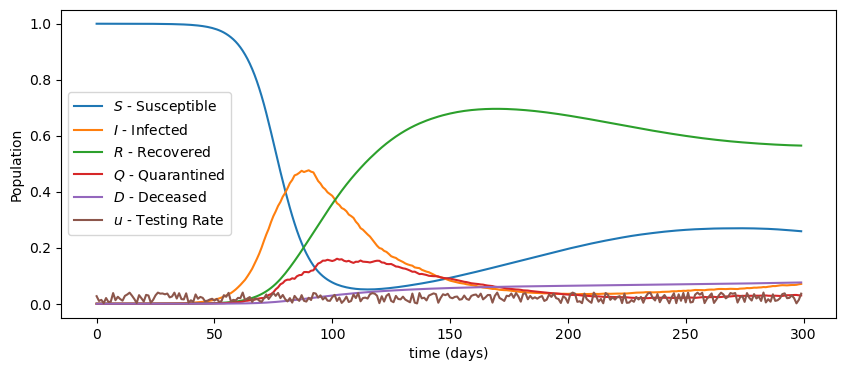

In [11]:
sample = simulate(sample_lenght, theta, u_max, u_min, epsilon)

plt.figure(figsize=(10,4))
plt.plot(sample[:,0], label = "$S$ - Susceptible")
plt.plot(sample[:,1], label = "$I$ - Infected")
plt.plot(sample[:,2], label = "$R$ - Recovered")
plt.plot(sample[:,3], label = "$Q$ - Quarantined")
plt.plot(sample[:,4], label = "$D$ - Deceased")
plt.plot(sample[:,5], label = "$u$ - Testing Rate")

plt.ylabel("Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("figures/sirq_model_sample.svg", bbox_inches='tight', format="svg")
plt.show()

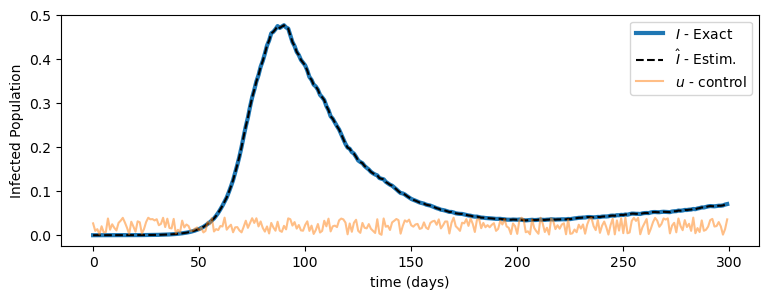

In [12]:
# expression to recover infected states
i_hat = (sample[1:,3] - sample[:-1,3]*(1-gamma_q-mu_q))/sample[:-1,-1]

plt.figure(figsize=(9,3))

plt.plot(sample[:,1], label = "$I$ - Exact", linewidth=3)
plt.plot(i_hat, '--', label = "$\\hat{I}$ - Estim.", color="k")
plt.plot(sample[:,-1], label = "$u$ - control", alpha=0.5)

plt.ylabel("Infected Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("figures/infected_observation.svg", bbox_inches='tight', format="svg")
plt.show()

## MPC from State Observer and Parameter Estimation

### LSTM-Based State Observer

In [18]:
def train_generator_observer(n_samples, input_lenght, u_max=0.04, u_min=0.001, theta_max=[1,0.1,0.1,0.01,0.01,0.01], scaler=None):
  while True:
    # formats data
    x_train = np.zeros((n_samples, input_lenght, 3))
    y_train = np.zeros((n_samples, input_lenght, 2))

    for i in range(n_samples):
      # samples random parameters
      theta = np.random.uniform(high=theta_max)

      # random initial state
      model = SIRQ(theta)
      
      # evolves inputs and outputs
      sample = simulate(input_lenght, theta, u_max, u_min, model=model)
      
      # updates train data
      x_train[i, :, :] = sample[:, [1,3,5]] # gets: I, Q, u
      y_train[i, :, :] = sample[:, [0,2]] # gets: S, R

      # checks for scaling
      if scaler is not None:
         x_train[i,:,:] = scaler.transform(x_train[i,:,:])

      # adjusts scale
      x_train[i,:,:] = x_train[i, :, :]

    yield x_train, y_train


def get_scaler_observer(n_samples, input_lenght, u_max=0.04, u_min=0.001, theta_max=[1,0.1,0.1,0.01,0.01,0.01]):
    # gets a sample generator
    generator = train_generator_observer(n_samples, input_lenght, u_max, u_min, theta_max)
    # samples then fit scaler
    x_train, _ = next(generator)
    x_train = np.vstack(x_train)
    scaler = MinMaxScaler().fit(x_train)
    
    return scaler

In [19]:
input_size = 3
output_size = 2

lstm_state_observer = tf.keras.models.Sequential()

#Adding LSTM layers
lstm_state_observer.add(tf.keras.layers.LSTM(10, return_sequences = True, input_shape = (None, input_size)))
lstm_state_observer.add(tf.keras.layers.LSTM(10, return_sequences = True))

#Adding the output layer
lstm_state_observer.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_size)))

# compiling
lstm_state_observer.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

# # summary
# print(regressorLSTM.summary())

In [ ]:
# scaler = get_scaler_observer(1000, 300, u_max=u_max, u_min=u_min)
# generator = train_generator_observer(100, 300, u_max=u_max, u_min=u_min, scaler=scaler)
generator = train_generator_observer(100, 300, u_max=u_max, u_min=u_min)

lstm_state_observer.fit(generator, steps_per_epoch=10000, epochs=20, verbose=1)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2046s 204ms/step - loss: 0.0174 - mean_absolute_error: 0.0799
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2082s 208ms/step - loss: 0.0034 - mean_absolute_error: 0.0385
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2260s 226ms/step - loss: 0.0025 - mean_absolute_error: 0.0319
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2013s 201ms/step - loss: 0.0023 - mean_absolute_error: 0.0298
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2012s 201ms/step - loss: 0.0022 - mean_absolute_error: 0.0288
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2012s 201ms/step - loss: 0.0021 - mean_absolute_error: 0.0279
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2010s 201ms/step - loss: 0.0020 - mean_absolute_error: 0.0273
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2008s 201ms/step - loss: 0.0019 - mean_absolute_error: 0.0266
Epoch 9/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2010s 201ms/step - loss: 0.0019 - mean_absolute_error: 0.0264
Epoch 10/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2

In [20]:
# filename = 'files/lstm_observer_mse_reinfection.keras'
filename = 'observer_files/lstm_state_observer.keras'

# save/load the model
# lstm_state_observer.save(filename)
lstm_state_observer = keras.models.load_model(filename)

#### Check Adjustment Results

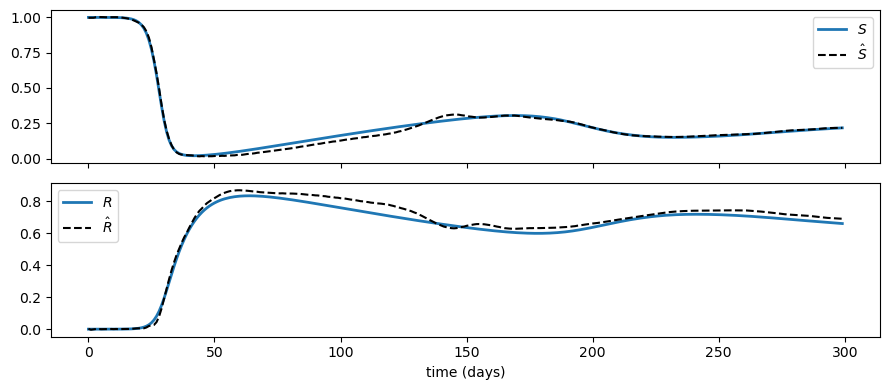

In [ ]:
# gets a random sample
generator = train_generator_observer(1, 300, u_max=u_max, u_min=u_min)
sample_x, sample_y = next(generator)
observed_y = lstm_state_observer.predict(sample_x)

# plot afjustments
fig, ax = plt.subplots(output_size, figsize=(9,4), sharex=True)

c = 0
for i, state in enumerate("SIRQD"):
    if state in "IQD":
        continue
    ax[c].plot(sample_y[0,:,c], label="${}$".format(state), linewidth=2)
    ax[c].plot(observed_y[0,:,c], "--", color="k", label="$\hat {}$".format(state))
    ax[c].legend()
    c += 1

plt.xlabel("time (days)")
fig.tight_layout()
plt.legend()
plt.savefig("observer_figures/lstm_observation.svg", bbox_inches='tight', format="svg")
plt.show()

### Model Dynamics and Integrators

In [21]:
# defines the dynamics under SIRQ model
def sirq_dynamics(x, u, theta):
    # states
    s, i, r, q, d = vertsplit(x)
    # params
    beta, gamma_i, gamma_q, mu_i, mu_q, delta = vertsplit(theta)

    # model
    sdot = delta*r - beta*s*i
    idot = beta*s*i - gamma_i*i - mu_i*i - u*i
    rdot = gamma_i*i + gamma_q*q - delta*r
    qdot = u*i - gamma_q*q - mu_q*q
    ddot = mu_i*i + mu_q

    return vertcat(sdot, idot, rdot, qdot, ddot)

In [23]:
# integrate with Explicit Euler
def integrate_euler(f, x0, u, theta, dt = 0.01, steps = 100):
    xj = x0
    for _ in range(steps):
        fj = f(xj,u,theta)
        xj += dt*fj
    return xj

In [16]:
# State and Control (symbolics)
u_ = MX.sym("u", 1)
x_ = MX.sym("x", 5)

# System parameters (symbolics)
theta_ = MX.sym("theta", 6)

# System dynamics (symbolics)
xdot_ = sirq_dynamics(x_,u_,theta_)
f_ = Function('f', [x_,u_,theta_],[xdot_])

# Discrete approximator function
xf_ = integrate_euler(f_, x_, u_, theta_)
F = Function('F', [x_,u_,theta_],[xf_])

### MSE Parameter Estimation


In [39]:
def estimate_theta(U, X_obs):
    n = len(X_obs)-1
    phi = np.zeros((5*n, 4))
    con = np.zeros((5*n, ))
    omh = np.zeros((5*n, ))
    aux1 = np.zeros((5*n, ))
    aux2 = np.zeros((5*n, ))
    # aux = np.zeros((5*n, ))
    for k in range(n):
        # extracts states
        S,I,R,Q,D = X_obs[k]
        
        # mount phi matrixes
        # phi[5*k:5*(k+1),:]= np.array([
        #     [-S*I, 0, 0, 0, 0, R],
        #     [S*I, -I, 0, -I, 0, 0],
        #     [0, I, Q, 0, 0, -R],
        #     [0, 0, -Q, 0, -Q, 0],
        #     [0, 0, 0, I, Q, 0],
        # ])
        phi[5*k:5*(k+1),:]= np.array([
            [-S*I, 0, 0, R],
            [S*I, -I, -I, 0],
            [0, I, 0, -R],
            [0, 0, 0, 0],
            [0, 0, I, 0],
        ])
        # mounts dX matrix
        omh[5*k:5*(k+1)] = X_obs[k+1] - X_obs[k]
        # mounts u matrixes
        con[5*k:5*(k+1)] = U[k]*np.array([0,-I,0,I,0]).ravel()
        # mounts auxiliary matrix
        aux1[5*k:5*(k+1)] = gamma_q*np.array([0,0,Q,-Q,0]).ravel()
        aux2[5*k:5*(k+1)] = mu_q*np.array([0,0,0,-Q,Q]).ravel()

    # solves system
    theta = np.linalg.lstsq(phi, omh-con-aux1-aux2, rcond=None)[0]
    return theta

### MPC Step - Optimal Control Computation 

In [19]:
def mpc_step_parameters(F, theta, X0, N, Cmax, Imax, c1=1, c2=10, c3=100):
    # Control for all segments
    U = MX.sym("U",N)

    # Integrate over all intervals
    X=[X0]
    for i in range(N-1):
        X.append(F(X[-1],U[i],theta))
    X = hcat(X)

    # S = X[0,:].T
    I = X[1,:].T
    # R = X[2,:].T
    Q = X[3,:].T
    # D = X[4,:].T

    # Objective function and constraints
    J = c1*mtimes(U.T, (1-Q)) + c2*mtimes(Q.T, Q) + c3*mtimes(I.T,I)
    G = I

    # NLP
    nlp = {'f':J, 'x':U, 'g':G}

    # Allocate an NLP solver
    opts = {"ipopt.print_level":0, "print_time":0}
    solver = nlpsol("solver", "ipopt", nlp, opts)


    # Bounds on u and initial condition
    arg = dict()
    # arg["x0"] = 0
    arg["lbx"] = u_min
    arg["ubx"] = u_max
    # arg["lbg"] = 0
    arg["ubg"] = Imax

    # Solve the problem
    res = solver(**arg)

    # Get the solution up to time step k
    return res["x"][0]

### Experiments and Results

In [20]:
def simulate_learning_based_mpc_parameters(theta, sample_lenght, N, c_max, i_max, c1, c2, c3, observation="exact", err_scale=1e+6):
    # initializes model
    model = SIRQ(theta)

    # iterativelly estimate, optimize and evolve the system
    states = np.zeros((sample_lenght, model.state.shape[0]+1))
    states_obs = np.zeros((sample_lenght, model.state.shape[0]+1))
    theta_estimated = np.zeros((sample_lenght, theta.shape[0]))

    # simulation
    for i in tqdm(range(sample_lenght)):
        # observed state
        if observation == "exact":
            err = np.random.normal(scale = model.state**2/err_scale, size=model.state.shape)
            states_obs[i,:-1] = model.state + err*[1,0,1,0,1]
        if observation == "lstm":
            observed_x = np.array([states[:i+1, [1,3,-1]]])
            observed_y = lstm_state_observer.predict(observed_x, verbose = 0)
            # updates observed states
            states_obs[:i+1,[1,3,-1]] = observed_x[0,:,:]
            states_obs[:i+1,[0,2]] = observed_y[0,:,:]
            states_obs[:i+1,4] = 1 - np.sum(states_obs[:i+1,:4], axis=1)
        states_obs[:,-1] = states[:,-1]

        # we estimate the parameters
        theta_mse = estimate_theta(states_obs[:i,-1], states_obs[:i+1,:-1]).ravel()
        theta_estimated[i,[0,1,3,5]] = theta_mse
        theta_estimated[i,2] = theta[2]
        theta_estimated[i,4] = theta[4]

        # solve mpc step with estimated parameters
        u = mpc_step_parameters(F, theta_estimated[i,:], states_obs[i,:-1], N, c_max, i_max, c1, c2, c3)

        # apply optimal steps and update environment
        states[i,-1] = u
        states[i,:-1] = model.update(u)

    return states, states_obs, theta_estimated

In [21]:
# define new parameters
beta = 0.04     # infection rate
gamma_i = 0.01  # recovery rate
gamma_q = 0.025 # recovery rate quarantine
mu_i = 0.002
mu_q = 0.001
delta = 0.001
theta = np.array([beta, gamma_i, gamma_q, mu_i, mu_q, delta])

N = 10 # mpc horison steps

sample_lenght = 300

#### Results: Exact Observations

In [40]:
solutions_observer_exact = simulate_learning_based_mpc_parameters(theta, 1000, N, c_max, i_max, c1, c2, c3, observation="exact")
states_exact, states_obs_exact, theta_estimated_exact = solutions_observer_exact

100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


In [ ]:
filename = "observer_files/solutions_observer_exact.pkl"

# # save results to file
# pkl.dump(solutions_observer_exact, open(filename, "wb"))

# loads results and unpacks
solutions_observer_exact = pkl.load(open(filename, "rb"))
states_exact, states_obs_exact, theta_estimated_exact = solutions_observer_exact

In [42]:
print("theta_exact:",theta)
print("theta_estim:",theta_estimated_exact[sample_lenght,:])

theta_exact: [0.04  0.01  0.025 0.002 0.001 0.001]
theta_estim: [0.03998984 0.00998899 0.025      0.00200055 0.001      0.00097446]


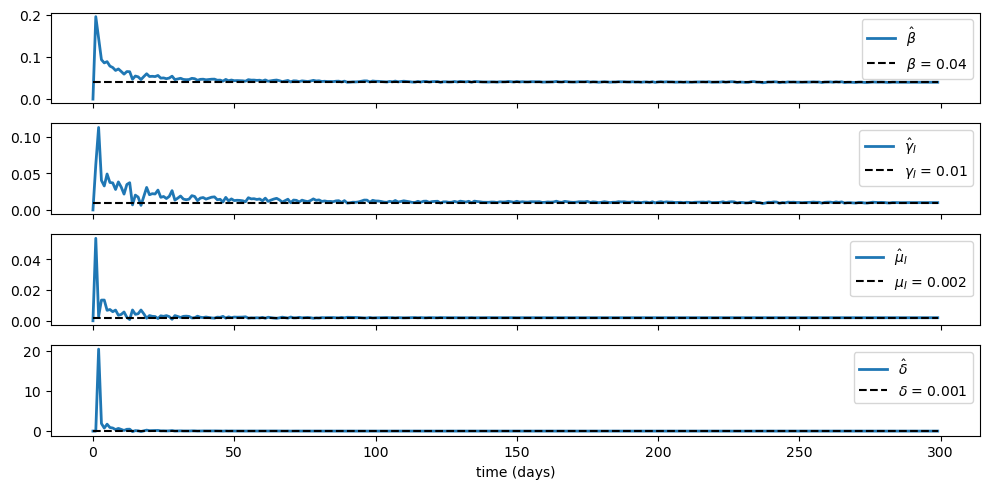

In [43]:
# plot the results
fig, ax = plt.subplots(4, figsize=(10,5), sharex=True)

# plot parameters

c = 0
for i, param in enumerate(["beta", "gamma_I", "gamma_Q", "mu_I", "mu_Q", "delta"]):
    if param in ["beta", "gamma_I", "mu_I", "delta"]:
        ax[c].plot(theta_estimated_exact[:sample_lenght,i], label = "$\\hat\\{}$".format(param), linewidth=2)
        ax[c].plot(theta[i] * np.ones((sample_lenght,)), "--", color="k", label = "$\\{}$ = {}".format(param, theta[i]))
        ax[c].legend()
        c+=1

# plt.savefig("observer_figures/param_est_exact.svg", bbox_inches='tight', format="svg")
plt.xlabel("time (days)")
fig.tight_layout()
plt.show()

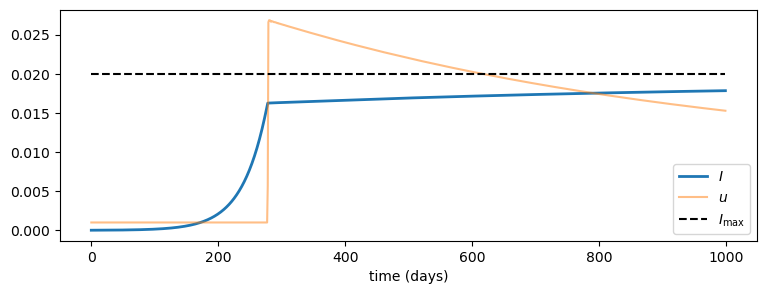

In [50]:
plt.figure(figsize=(9,3))

plt.plot(states_exact[:,1], label = "$I$", linewidth=2)
plt.plot(states_exact[:,-1], label="$u$", alpha=0.5)
plt.plot(i_max * np.ones((len(states_exact),)), "--", color="k", label = "$I_{\max}$")
plt.legend()

plt.xlabel("time (days)")
fig.tight_layout()
# plt.savefig("observer_figures/epidemic_mitigation_exact.svg", bbox_inches='tight', format="svg")
plt.show()

### Results: LSTM-Based Observations

In [44]:
solutions_observer_lstm = simulate_learning_based_mpc_parameters(theta, 1000, N, c_max, i_max, c1, c2, c3, observation="lstm")
states_lstm, states_obs_lstm, theta_estimated_lstm = solutions_observer_lstm

100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


In [ ]:
filename = "observer_files/solutions_observer_lstm.pkl"

# # save results to file
# pkl.dump(solutions_observer_lstm, open(filename, "wb"))

# loads results and unpacks
solutions_observer_lstm = pkl.load(open(filename, "rb"))
states_lstm, states_obs_lstm, theta_estimated_lstm = solutions_observer_lstm

In [48]:
# print
print("theta_exact:",theta)
print("theta_estim:",theta_estimated_lstm[sample_lenght,:])

theta_exact: [0.04  0.01  0.025 0.002 0.001 0.001]
theta_estim: [ 0.14920417  0.12272634  0.025       0.04845207  0.001      -0.0219118 ]


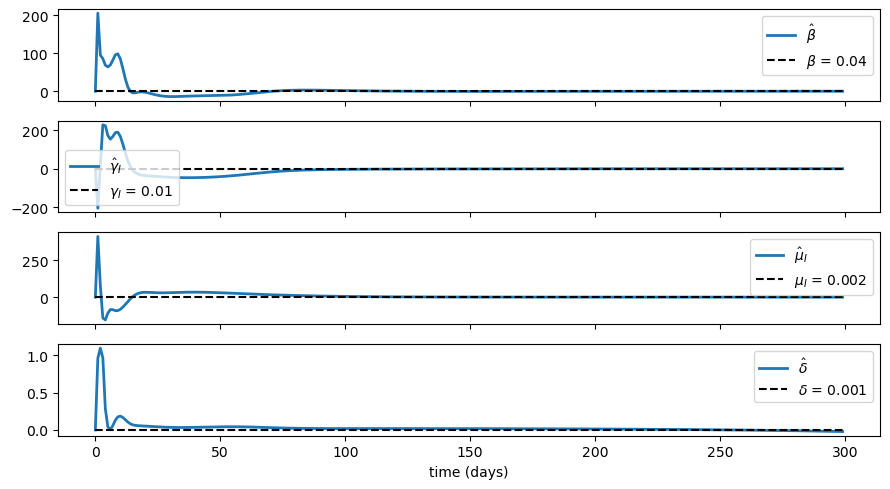

In [46]:
# plot the results
fig, ax = plt.subplots(4, figsize=(9,5), sharex=True)

# plot parameters

c = 0
for i, param in enumerate(["beta", "gamma_I", "gamma_Q", "mu_I", "mu_Q", "delta"]):
    if param in ["beta", "gamma_I", "mu_I", "delta"]:
        ax[c].plot(theta_estimated_lstm[:sample_lenght:,i], label = "$\\hat\\{}$".format(param), linewidth=2)
        ax[c].plot(theta[i] * np.ones((sample_lenght,)), "--", color="k", label = "$\\{}$ = {}".format(param, theta[i]))
        ax[c].legend()
        c+=1

# plt.savefig("observer_figures/param_est_lstm.svg", bbox_inches='tight', format="svg")
plt.xlabel("time (days)")
fig.tight_layout()
plt.show()

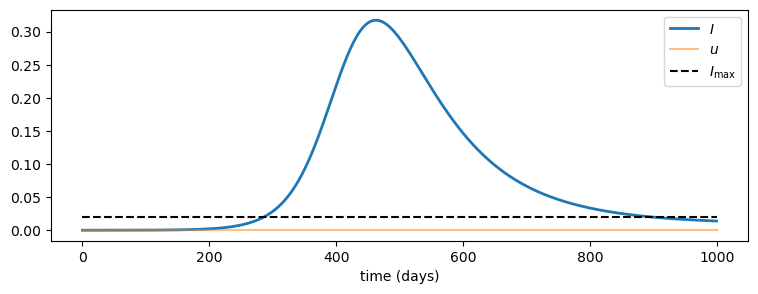

In [49]:
plt.figure(figsize=(9,3))

plt.plot(states_lstm[:,1], label = "$I$".format(param), linewidth=2)
plt.plot(states_lstm[:,-1], label="$u$", alpha=0.5)
plt.plot(i_max * np.ones((len(states_lstm),)), "--", color="k", label = "$I_{\max}$")
plt.legend()

plt.xlabel("time (days)")
fig.tight_layout()
# plt.savefig("observer_figures/epidemic_mitigation_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### Comparison

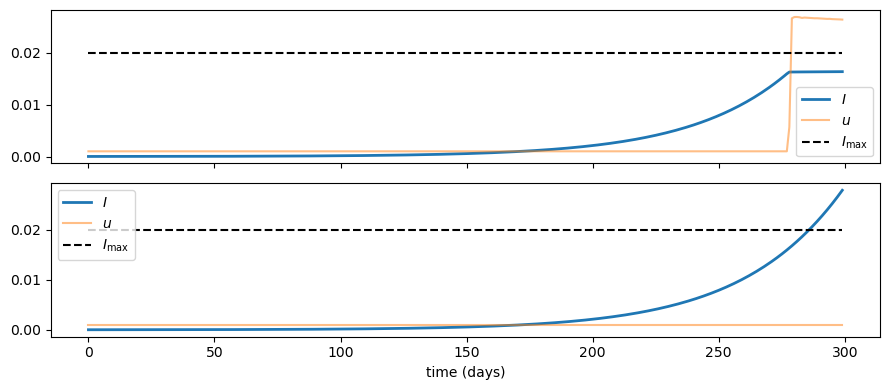

In [52]:
fig, ax = plt.subplots(2, figsize=(9,4), sharex=True)

ax[0].plot(states_exact[:sample_lenght,1], label = "$I$".format(param), linewidth=2)
ax[0].plot(states_exact[:sample_lenght,-1], label="$u$", alpha=0.5)
ax[0].plot(i_max * np.ones((sample_lenght,)), "--", color="k", label = "$I_{\max}$")
ax[0].legend()

ax[1].plot(states_lstm[:sample_lenght,1], label = "$I$".format(param), linewidth=2)
ax[1].plot(states_lstm[:sample_lenght,-1], label="$u$", alpha=0.5)
ax[1].plot(i_max * np.ones((sample_lenght,)), "--", color="k", label = "$I_{\max}$")
ax[1].legend()

# plt.savefig("observer_figures/param_est_exact.svg", bbox_inches='tight', format="svg")
plt.xlabel("time (days)")
fig.tight_layout()
plt.show()

## MPC from Control-Free State Evolution Predictor

### LSTM-Based Control-Free State Predictor

In [13]:
input_lenght = 30
output_lenght = 10

In [14]:
def train_generator(n_samples, input_lenght=10, output_lenght=10, u_max=0.04, u_min=0.001, theta_max=[1,0.1,0.1,0.01,0.01,0.01]):
  while True:
    # formats data
    x_train = np.zeros((n_samples, input_lenght, 2))
    y_train = np.zeros((n_samples, output_lenght, 2))

    for sample in range(n_samples):
      # samples random parameters
      theta = np.random.uniform(high=theta_max)

      # random initial state
      model = SIRQ(theta)
      state = np.random.rand(5)
      model.state = state/sum(state)
      
      # evolves inputs and outputs
      inputs = simulate(input_lenght, theta, u_max, u_min, model=model)
      outputs = simulate(output_lenght, theta, 0, 0, model=model)
      
      # updates train data
      x_train[sample, :, :] = inputs[:, [1,-1]]
      y_train[sample, :, :] = outputs[:, [1,-1]]

    yield x_train, y_train

In [15]:
@keras.saving.register_keras_serializable()
class FeedBack(keras.Model):
    def __init__(self, units, out_steps, out_features, **kwargs):
        super().__init__(**kwargs)

        # parameters
        self.units = units
        self.out_steps = out_steps
        self.out_features = out_features
        
        # layers
        self.cell = keras.layers.LSTMCell(units)
        self.dense = keras.layers.Dense(out_features)
        self.rnn = keras.layers.RNN(self.cell, return_state=True)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state


    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

    def get_config(self):
        base_config = super().get_config()

        config = {
            "units": self.units,
            "out_steps": self.out_steps,
            "out_features": self.out_features,
            "cell": keras.saving.serialize_keras_object(self.cell),
            "dense": keras.saving.serialize_keras_object(self.dense),
            "rnn": keras.saving.serialize_keras_object(self.rnn),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # deserialize layers
        cell = keras.saving.deserialize_keras_object(config.pop("cell"))
        dense = keras.saving.deserialize_keras_object(config.pop("dense"))
        rnn = keras.saving.deserialize_keras_object(config.pop("rnn"))
        
        # generate model
        model = cls(config.pop("units"), config.pop("out_steps"), config.pop("out_features"), **config)
        model.cell = cell
        model.dense = dense
        model.rnn = rnn
        
        return model


In [27]:
lstm_state_predictor = FeedBack(units=4, out_steps=10, out_features=2)

lstm_state_predictor.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

# print(lstm_state_predictor.summary())

In [ ]:
generator = train_generator(1000, input_lenght, output_lenght, u_max=u_max, u_min=u_min)
lstm_state_predictor.fit(generator, steps_per_epoch=1000, epochs=10, verbose=1)

In [16]:
filename = 'predictor_files/lstm_state_predictor.keras'
# filename = 'predictor_files/lstm_state_predictor - other.keras'

# save/load the model
# lstm_state_predictor.save(filename)
lstm_state_predictor = keras.models.load_model(filename)

#### Check Fitting

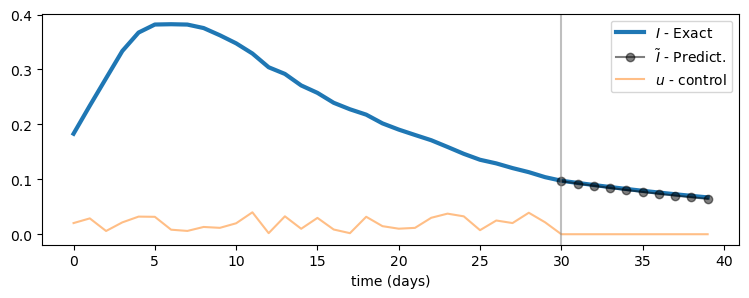

In [ ]:
generator = train_generator(1, input_lenght, output_lenght, u_max=u_max, u_min=u_min)
sample_input, sample_output = next(generator)

plt.figure(figsize=(9,3))

plt.plot(range(input_lenght + output_lenght), np.concatenate([sample_input[0, :, 0], sample_output[0, :, 0]]), label="$I$ - Exact", linewidth=3)

prediction = np.zeros((output_lenght, 2))
prediction[:,0] = np.arange(input_lenght, input_lenght + output_lenght)
prediction[:,1] = lstm_state_predictor(sample_input)[0,:,0]
plt.plot(prediction[:,0], prediction[:,1], "-o", color="k", label="$\\tilde{I}$ - Predict.", alpha=0.5)

plt.plot(range(input_lenght + output_lenght), np.concatenate([sample_input[0, :, 1], sample_output[0, :, 1]]), label = "$u$ - control", alpha=0.5)

plt.axvline(input_lenght, color="gray", alpha=0.5)

plt.xlabel("time (days)")


plt.legend()
plt.savefig("fig/infected_prediction.svg", bbox_inches='tight', format="svg")
plt.show()

In [218]:
predictions = []

for i in range(input_lenght, sample_lenght):
    prediction = np.zeros((output_lenght, 2))
    prediction[:,0] = np.arange(i, i+output_lenght)
    prediction[:,1] = lstm_state_predictor(np.array([sample[i-input_lenght:i,[1,-1]]]))[0,:,0]
    
    predictions.append(prediction)

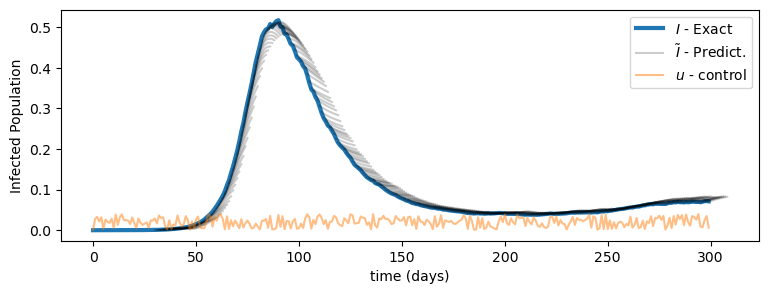

In [220]:
plt.figure(figsize=(9,3))

plt.plot(sample[:, 1], label="$I$ - Exact", linewidth=3)

for prediction in predictions:
    line, = plt.plot(prediction[:,0], prediction[:,1], color="k", alpha=0.2)
line.set_label("$\\tilde{I}$ - Predict.")

plt.plot(sample[:,-1], label = "$u$ - control", alpha=0.5)

plt.ylabel("Infected Population")
plt.xlabel("time (days)")

plt.legend()
plt.savefig("predictor_figures/infected_prediction_many.svg", bbox_inches='tight', format="svg")
plt.show()

### Control Law and MPC

In [18]:
n = 10
h = 1/n

In [75]:
def mpc_minimal_control(strategy, i_pred):
    # maximun index to be controlled
    k = 1 + np.argmax(i_pred[1:])

    if strategy == "one-step":
        w = (i_pred[k] - i_max)/i_pred[k-1]
                
    if strategy == "translation":
        w = (i_pred[k] - i_max)/np.sum(i_pred[:k])

    if strategy == "propagation":
        w = symbols("w")
        eq = i_pred[0] * (1-w)**k
        for n in range(k):
            eq += (i_pred[n+1]-i_pred[n])*(1 - w)**(k-n-1)
        solutions = solve(eq - i_max, w, rational=False, check=False)
        w = [s for s in solutions if s.is_real]
        w = sorted(w)[0]
                
    if strategy == "proportional":
        w = symbols("w")
        eq = i_pred[0]
        for n in range(k):
            eq *= (i_pred[n+1]/i_pred[n] - w)
        solutions = solve(eq - i_max, w, rational=False, check=False)
        w = [s for s in solutions if s.is_real]
        w = sorted(w)[0]
    
    return w

In [76]:
def mpc_optimal_control_gekko(strategy, i_pred, x0, u_min, u_max):
    # start model
    gekko_model = GEKKO()
    gekko_model.time = np.linspace(0, output_lenght-1, len(i_pred))

    # I = gekko_model.Var(x0[0])
    I_ = gekko_model.Param(i_pred) # \tilde{I}
    Q = gekko_model.Var(x0[1])
    u = gekko_model.Var(lb=u_min, ub=u_max)
    gekko_model.free(u)

    if strategy == "translation":
        # gekko_model.Equation(I.dt() == I_.dt() - u * I_)
        aux = gekko_model.integral(u*I_)
        I = gekko_model.Intermediate(I_ - aux)
    
    if strategy == "propagation":
        # gekko_model.Equation(I.dt() == I_.dt() - u * I)
        aux1 = gekko_model.integral(u)
        aux2 = gekko_model.Intermediate( np.e**(-aux1) )
        aux3 = gekko_model.integral(u * aux2**(-1) * I_ )
        I = gekko_model.Intermediate(I_ + x0[0]*(1-aux2) - aux2 * aux3 )

    if strategy == "proportional":
        # gekko_model.Equation(I.dt() == I_.dt() * I/I_ - u*I)
        aux1 = gekko_model.integral(u)
        aux2 = gekko_model.Intermediate( np.e**(-aux1) )
        I = gekko_model.Intermediate(I_*aux2)
                
    gekko_model.Equation(Q.dt() == u*I - gamma_q*Q - mu_q*Q)

    # mitogation
    gekko_model.Equation(I <= i_max)

    # costs
    gekko_model.Minimize(c1*(u*(1-Q))**2 + c2*Q**2 + c3*I**2)

    # solve
    # try:
    if True:
        gekko_model.options.MAX_ITER = 1000
        gekko_model.options.IMODE = 6
        gekko_model.solve(disp=False)

        w = u.VALUE[1:n+1]
    # except:
    #     print("Warning:", "error solving problem. Returning maximun control.")
    #     w = [u_max]*n
    
    return w

In [77]:
def mpc_optimal_control_casadi(strategy, I_pred, X0, u_min, u_max):
    # Control for all segments
    Ut = MX.sym("U", output_lenght*n)

    # strategies
    if strategy == "translation":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1]) 
    
    if strategy == "propagation":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1])

    if strategy == "proportional":
        F = lambda I, i, I_pred: (I_pred[i] - I_pred[i-1])*I/I_pred[i-1]

    # Integrate over all intervals
    X=[X0]
    for i in range(1, output_lenght*n):
        # X.append(integrate_euler(X[-1],Ut[i-1], i_pred))
        X_ = X[-1] + h*sirq_dynamics_(X[-1],Ut[i-1], F, i, I_pred)
        X.append(X_)
    X = hcat(X)

    I = X[0,:].T
    Q = X[1,:].T

    # Objective function and constraints
    J = c1*mtimes((Ut**2).T, (1-Q)**2) + c2*mtimes(Q.T, Q) + c3*mtimes(I.T, I)
    G = I

    # NLP
    nlp = {'f':J, 'x':Ut, 'g':G}

    # Allocate an NLP solver
    opts = {"ipopt.tol":1e-10, "expand":True,
            "ipopt.print_level":0, "ipopt.sb":"yes", "print_time":0}
    solver = nlpsol("solver", "ipopt", nlp, opts,)

    # Bounds on u and initial condition
    arg = dict()
    #   arg["x0"] = 0
    arg["lbx"] = u_min
    arg["ubx"] = u_max
    #   arg["lbg"] = 0
    arg["ubg"] = i_max

    # Solve the problem
    res = solver(**arg)

    # Get the optimal solution
    return np.array(res["x"]), float(res["f"])


def sirq_dynamics_(x, u, F, i, I_pred):
    # unpack states 
    I = x[0] # infected
    Q = x[1] # quarantine

    # ODE right hand side
    idot = F(I, i, I_pred) - u*I
    qdot = u*I - gamma_q*Q - mu_q*Q

    return vertcat(idot, qdot)

In [68]:
def get_functions_(strategy, I_pred, u_min, u_max):
    # # defining model dependent systems
    # if strategy == "translation":
    #     # model functions
    #     F = lambda i, x_i: I_pred[i] - I_pred[i-1]
    #     F_I = lambda i, x_i: 0
    #     # system for I
    #     f_x_I = lambda i, x_i, u_i: F(i, x_i) - u_i*I_pred[i]
    #     # system for p0
    #     f_p_1 = lambda i, p_i, x_i, u_i: -p_i[0]*(F_I(i, x_i)-u_i) - p_i[1]*u_i - p_i[2]*2*c3*x_i[0]
    
    if strategy == "propagation":
        F = lambda i, x_i: (I_pred[i] - I_pred[i-1])/h
        F_I = lambda i, x_i: 0
        f_x_I = lambda i, x_i, u_i: F(i, x_i) - u_i*x_i[0]
        # system for p0
        f_p_1 = lambda i, p_i, x_i, u_i: -p_i[0]*(F_I(i, x_i)-u_i) - p_i[1]*u_i - p_i[2]*2*c3*x_i[0]

    # if strategy == "proportional":
    #     F = lambda i, x_i: (I_pred[i] - I_pred[i-1])*x_i[0]/I_pred[i-1]
    #     F_I = lambda i, x_i: (I_pred[i] - I_pred[i-1])/I_pred[i-1]
    #     F_I_t = lambda i, x_i: None
    #     F_I_I = lambda i, x_i: None
    #     # system for I
    #     f_x_I = lambda i, x_i, u_i: F(i, x_i) - u_i*x_i[0]
    #     # system for p0
    #     f_p_1 = lambda i, p_i, x_i, u_i: -p_i[0]*(F_I(i, x_i)-u_i) - p_i[1]*u_i - p_i[2]*2*c3*x_i[0]

    # fixed system for Q, L
    f_x_Q = lambda i, x_i, u_i: u_i * x_i[0] - gamma_q*x_i[1] - mu_q*x_i[1]
    f_x_L = lambda i, x_i, u_i: c1*(u_i*(1 - x_i[1]))**2 + c2*x_i[1]**2 + c3*x_i[0]**2
    # foxed system for p1,p2
    f_p_2 = lambda i, p_i, x_i, u_i: -p_i[0]*0 + p_i[1]*(gamma_q + mu_q) + p_i[2]*(c1*u_i**2*(1-x_i[1])+2*c2*x_i[1])
    f_p_3 = lambda i, p_i, x_i, u_i: -p_i[0]*0 - p_i[1]*0 - p_i[2]*0
    # defining complete systems for x, p
    f_x = lambda i, x_i, u_i: np.array([f_x_I(i, x_i, u_i), f_x_Q(i, x_i, u_i), f_x_L(i, x_i, u_i)])
    f_p = lambda i, p_i, x_i, u_i: np.array([f_p_1(i, p_i, x_i, u_i), f_p_2(i, p_i, x_i, u_i), f_p_3(i, p_i, x_i, u_i)])

    # defining u = argmax p*f
    def f_u(i, p_i, x_i, u_i):
        # unpack states
        I, Q, L = x_i
        p_1, p_2, p_3 = p_i

        w = (p_1*I-p_2*I)/(p_3*2*(1-Q)**2)
        
        # # switching function
        # switching_i = -p_1*I + p_2*I + p_3*c1*(1-Q)
        
        # # check conditions
        # if switching_i > 1e-5:
        #     w = u_min
        # elif switching_i < -1e-5:
        #     w = u_max
        # else:
        #     # unpack derivatives
        #     I_dt, Q_dt, L_dt = f_x(i, x_i, u_i)
        #     p1_dt, p2_dt, p3_dt = f_p(i, p_i, x_i, u_i)

        #     # derivative of switching function
        #     switching_i_dt = (-p1_dt*I-p_1*I_dt)+(p2_dt*I+p_2*I_dt)+(p3_dt*c1*(1-Q) - p_3*c1*Q_dt)

        #     # checks conditions
        #     if switching_i_dt > 1e-1:
        #         w = u_min
        #     elif switching_i_dt < -1e-1:
        #         w = u_max
        #     else:
        #         c_Q = c2
        #         c_I = c3

        #         A = (- p_1*F_I(i, x_i)**2*I - 2*c_I*p_3*F_I(i, x_i)*I**2 + p_1*F_I_t(i, x_i)*I + p_1*F_I_I(i, x_i)*F(i, x_i)*I
        #             + p_1*F_I(i, x_i)*F(i, x_i) + 6*c_I*p_3*I*F(i, x_i) - p_1*F_t(i, x_i) + gamma_q**2*p_2*I + 2*gamma_q*mu_q*p_2*I
        #             - 2*gamma_q*c_Q*p_3*Q*I + 2*gamma_q*p_2*F(i, x_i) + mu_q**2*p_2*I + 2*mu_q*p_2*F(i, x_i) + 2*c_Q*gamma_q*p_3*Q
        #             - 4*c_Q*p_3*Q*F(i, x_i) + p_2*F_t(i, x_i) + p_2*F_I(i, x_i)*F(i, x_i) - gamma_q**2*p_3*Q - 2*gamma_q*mu_q*p_3*Q - mu_q**2*p_3*Q)
        
        #         B =  (- 2*p_2*F_I(i, x_i)*I - p_1*F_I_I(i, x_i)*I**2 - 4*c_I*p_3*I**2 - p_1*F(i, x_i) + p_2*F(i, x_i) + p_1*F_I(i, x_i)*I
        #             + 2*gamma_q*p_3*I - gamma_q*p_2*I + 2*mu_q*p_3*I - mu_q*p_2*I - 2*c_Q*p_3*I**2 + 2*c_Q*p_3*Q*I + p_3*F(i, x_i))
        
        #         w = -A/B
        
        # # clips to the feasible interval
        return np.clip(w, a_min=u_min, a_max=u_max)
    
    return f_x, f_p, f_u

In [78]:
def sweep_method_step(x, p, u, x_0, p_t, f_x, f_p, f_u):
    # updates x(t) forwards in time
    x[:,0] = x_0
    for i in range(1, output_lenght*n):
        x[:,i] = x[:,i-1] + h*f_x(i-1, x[:,i-1], u[i-1])
    
    # updates p(t) backwards in time
    p[:,-1] = p_t
    for i in range(output_lenght*n-1, 0, -1):
        p[:,i-1] = p[:,i] - h*f_p(i,p[:,i], x[:,i], u[i-1]) # attention to the signals

    # updates u(t) at each time
    for i in range(output_lenght*n-1):
        u[i] = f_u(i, p[:,i], x[:,i], u[i])

    return x, p, u

def shooting_method_step(x, p, u, x_0, p_0, f_x, f_p, f_u):
    # updates x(t) and p(t) forwards in time
    x[:,0] = x_0
    p[:,0] = p_0
    for i in range(1,output_lenght*n):
        u[i-1] = f_u(i-1, p[:,i-1], x[:,i-1], u[i-1])
        x[:,i] = x[:,i-1] + h*f_x(i-1, x[:,i-1], u[i-1])
        p[:,i] = p[:,i-1] + h*f_p(i-1, p[:,i-1], x[:,i-1], u[i-1]) # attention to the signals

    return x, p, u

# def shooting_method_step_p_0(x, p, u, x_0, p_0, p_t, f_x, f_p, f_u, epsilon=1e-8):
#     p_0_diff = np.zeros((len(p_0), len(p_0)))
    
#     for i in range(len(p_0)):
#         aux = np.zeros(len(p_0))
#         aux[i] += epsilon
#         _, p_0_f_eps_p, _ = shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0+aux, f_x, f_p, f_u)
#         _, p_0_f_eps_m, _ = shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0-aux, f_x, f_p, f_u)
#         p_0_diff[:,i] = (p_0_f_eps_p[:,-1] - p_0_f_eps_m[:,-1])/(2*epsilon)
    
#     _, p_0_f_0, _ = shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0, f_x, f_p, f_u)
#     p_0_newton = p_0 - np.linalg.solve(p_0_diff, p_0_f_0[:,-1]-p_t)

#     return p_0_newton
    
#     err_p_0 = np.linalg.norm(p_0_f_0[:,-1]-p_t)
#     _, p_newton_f_0, _ = shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0_newton, f_x, f_p, f_u)
#     err_newton = np.linalg.norm(p_newton_f_0[:,-1]-p_t)
#     if err_newton < err_p_0:
#         return p_0_newton
#     else:
#         # finds the best shot on line
#         stepsize = 0.01
#         best_p_0 = p_0_f_0[:,-1].copy()
#         best_error = np.linalg.norm(p_0_f_0[:,-1]-p_t)
#         for alpha in np.arange(0, 1, stepsize):
#             p_alpha = p_0*(1-alpha) + p_0_newton*alpha
#             _, p_alpha_f_0, _ = shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_alpha, f_x, f_p, f_u)
#             error = np.linalg.norm(p_alpha_f_0[:,-1]-p_t)
#             if error < best_error:
#                 best_error = error
#                 best_p_0 = p_alpha

#         return best_p_0

from scipy.optimize import root

def shooting_method_step_p_0(x, p, u, x_0, p_0, p_t, f_x, f_p, f_u):
    root_scalar_f = lambda p_0: shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0.copy(), f_x, f_p, f_u)[1][:,-1] - p_t
    res = root(root_scalar_f, x0=p_0)
    return res["x"]

def mpc_optimal_control_numerical(method, strategy, i_pred, x_0, u_min, u_max, N=1000, tol=1e-10):
    p_t = np.array([0,0,1])
    p_0 = np.array([1,1,1])
    # p_0 = np.random.rand(3)
    x_0 = np.array([*x_0, 0])

    u = np.zeros(output_lenght*n)
    x = np.zeros((3, output_lenght*n))#; x[:,0] = x_0
    p = np.ones((3, output_lenght*n))#; p[:,-1] = p_t
    
    # defines mappings
    f_x, f_p, f_u = get_functions_(strategy, i_pred, u_min, u_max)

    for i in range(N):
        x_old, p_old, u_old = x.copy(), p.copy(), u.copy()

        if method == "sweep":
            x, p, u = sweep_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_t.copy(), f_x, f_p, f_u)
        
        if method == "shooting":
            p_0 = shooting_method_step_p_0(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), p_t.copy(), f_x, f_p, f_u) 
            x, p, u = shooting_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), f_x, f_p, f_u)
        
        states = np.concatenate([arr.ravel() for arr in (x, p, u)])
        states_old = np.concatenate([arr.ravel() for arr in (x_old, p_old, u_old)])
        stopping_criterion_error = np.linalg.norm(states - states_old)/np.linalg.norm(states) 
        
        # check for stopping condition
        if stopping_criterion_error < tol:
            break
    else:
        print("warning: maximun iteration reached. criterion:", stopping_criterion_error)

    return u, x[-1,-1]

In [80]:
def predict(prediction, epsilon_i, i, x0=None, states=None, w=0):
    if prediction == "lstm":
        i_pred = lstm_state_predictor(np.array([states[i-input_lenght:i, [1, -1]]]))[0,:,0]

    if prediction == "exact":
        model = SIRQ(theta)
        model.state = x0
        i_pred = []
        for _ in range(output_lenght):
            for _ in range(n):
                model.update(w, h=h)
            i_pred.append(model.state)
        i_pred = np.array(i_pred)[:,1]

    # used interpolating splines
    spl = make_interp_spline(np.linspace(0, len(i_pred), len(i_pred)), i_pred)
    i_pred = spl(np.linspace(0, len(i_pred), output_lenght*n))

    return np.clip(i_pred, a_min=epsilon_i, a_max=1)

def control_cost_real(theta, state, w):
    model = SIRQ(theta)
    model.state = state.copy()
    
    states = np.zeros((output_lenght*n, len(model.state) + 1))

    # updates system
    for j, w_ in enumerate(w):
        state = model.update(w_, h=h)
        states[j,:-1] = state
        states[j, -1] = w_
    
    # computes costs
    cost = c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2
    cost = h*np.sum(cost)
    return cost


def simulate_learning_based_mpc(theta, simulation_lenght, start_lenght, epsilon_i=1e-10,
                                strategy=None, prediction=None, problem=None):
    
    # initiates model simulator
    model = SIRQ(theta)

    # initiates states
    states = np.zeros((simulation_lenght*n, len(model.state) + 1))
    report = {"mpc_controls": [], "mpc_costs": [], "real_costs":[]}


    # simulates under control
    for i in tqdm(range(0, simulation_lenght*n, n)):
        # prediction stategies
        if strategy is None or prediction is None or problem is None or i < start_lenght*n:
            w = u_min*np.ones(n)
        else:
            # prediction
            i_pred = predict(prediction, epsilon_i, i, model.state, states)
            x0 = (i_pred[0], model.state[3])

            # minimal control
            if problem == "minimal_control":
                w = mpc_minimal_control(strategy, i_pred)
                w = np.clip(w, a_min=u_min, a_max=u_max)
                l = w*n # constant control for the hoziron
            
            # using solvers
            if problem == "gekko":
                w,l = mpc_optimal_control_gekko(strategy, i_pred, x0, u_min, u_max)
            if problem == "casadi":
                w,l = mpc_optimal_control_casadi(strategy, i_pred, x0, u_min, u_max)
            
            # numerical method
            if problem == "sweep":
                w,l = mpc_optimal_control_numerical(problem, strategy, i_pred, x0, u_min, u_max)
            if problem == "shooting":
                w,l = mpc_optimal_control_numerical(problem, strategy, i_pred, x0, u_min, u_max)

        # compute real cost by strategy
        # l = control_cost_pred(theta, i_pred, x0, w)
        r = control_cost_real(theta, model.state, w)
        
        # updates mpc reports
        report["mpc_costs"].append(l)
        report["real_costs"].append(r)
        report["mpc_controls"].append(w)
             
        # updates system using mpc control up to step n
        for j, w_ in enumerate(w[:n]):
            state = model.update(w_, h=h)
            states[i+j, :-1] = state
            states[i+j, -1] = w_

    # returns
    return states, report


In [31]:
# strategies = ["one-step", "translation", "propagation", "proportional"]
strategies = ["translation", "propagation", "proportional"]
equations = [
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t)) + g(t,\\tilde{x}(t), u(t))$",
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t)) + g(t,\hat{x}(t), u(t))$",
    "$\\frac{d}{dt}\hat{x}(t) = f(t,\\tilde{x}(t))\\frac{\hat{x}(t)}{\\tilde{x}(t)} + g(t,\hat{x}(t), u(t))$"]

### Minimal Testing for Control

In [247]:
solutions_pred_minimal_exact = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(theta, simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="exact", problem="minimal_control")
    solutions_pred_minimal_exact.append(states)

100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


In [ ]:
filename = "predictor_files/solutions_pred_minimal_exact.pkl"

# pkl.dump(solutions_pred_minimal_exact, open(filename, "wb"))
solutions_pred_minimal_exact = pkl.load(open(filename, "rb"))

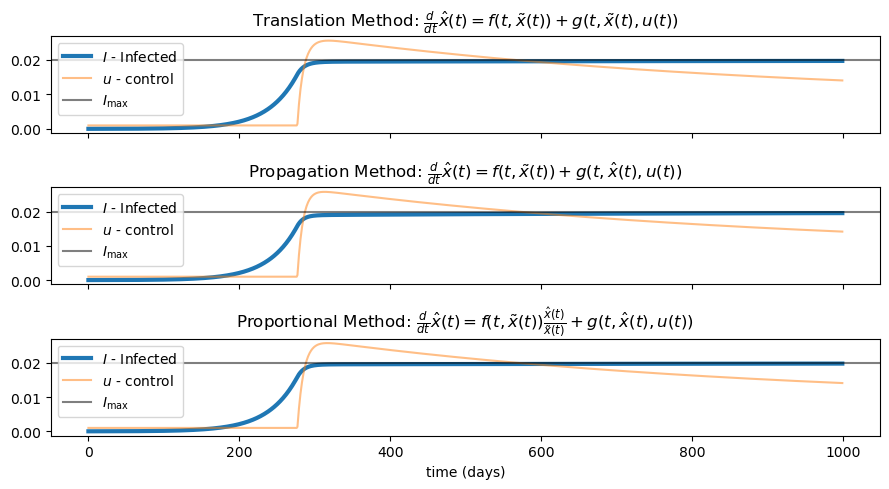

In [250]:
fig, ax = plt.subplots(len(strategies), figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, states)  in enumerate(zip(strategies, equations, solutions_pred_minimal_exact)):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=3)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.5)
    ax[i].axhline(i_max, label="$I_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_minimal_exact.svg", bbox_inches='tight', format="svg")
plt.show()

In [251]:
solutions_pred_minimal_lstm = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(theta, simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="lstm", problem="minimal_control",)
    solutions_pred_minimal_lstm.append(states)

100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]


In [ ]:
filename = "predictor_files/solutions_pred_minimal_lstm.pkl"

# pkl.dump(solutions_pred_minimal_lstm, open(filename, "wb"))
solutions_pred_minimal_lstm = pkl.load(open(filename, "rb"))

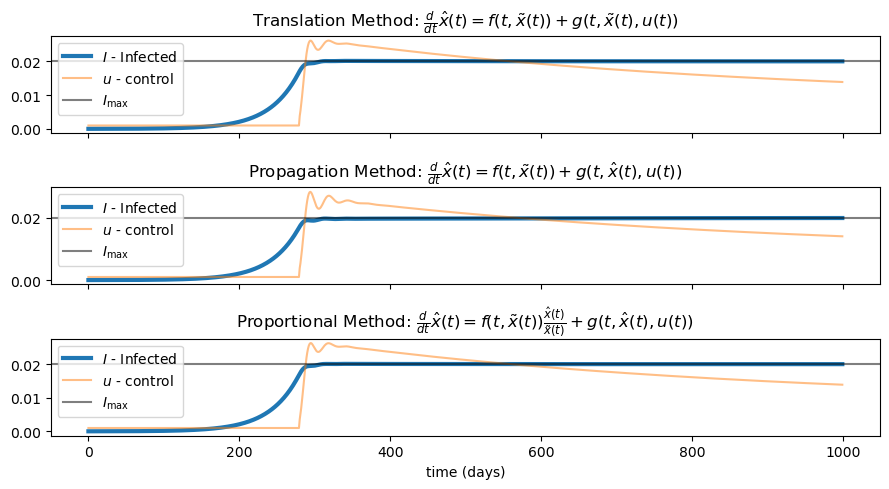

In [253]:
fig, ax = plt.subplots(len(strategies), figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, states)  in enumerate(zip(strategies, equations, solutions_pred_minimal_lstm)):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=3)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.5)
    ax[i].axhline(i_max, label="$I_{\max}$", color="k", alpha=0.5)
    
    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_minimal_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### Optimal Control Problem

In [91]:
solutions_pred_optimal_exact = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(theta,simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="exact", problem="optimal_control_casadi")
    solutions_pred_optimal_exact.append(states)

100%|██████████| 1000/1000 [04:13<00:00,  3.94it/s]


In [ ]:
filename = "predictor_files/solutions_pred_optimal_exact.pkl"

# pkl.dump(solutions_pred_optimal_exact, open(filename, "wb"))
solutions_pred_optimal_exact = pkl.load(open(filename, "rb"))

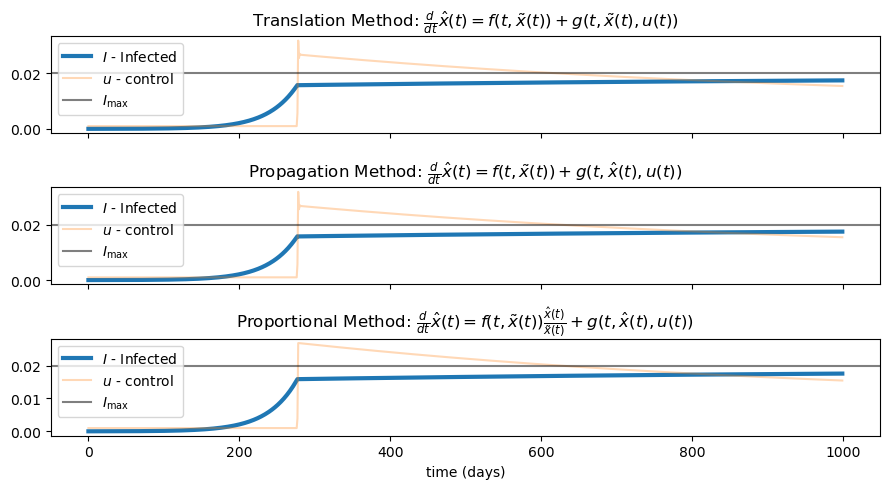

In [140]:
fig, ax = plt.subplots(3, figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, states)  in enumerate(zip(strategies, equations, solutions_pred_optimal_exact)):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=3)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.3)
    ax[i].axhline(i_max, label="$I_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_optimal_exact.svg", bbox_inches='tight', format="svg")
plt.show()

In [138]:
solutions_pred_optimal_lstm = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(theta, simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="lstm", problem="optimal_control_casadi")
    solutions_pred_optimal_lstm.append(states)

100%|██████████| 1000/1000 [04:55<00:00,  3.39it/s]


In [ ]:
filename = "predictor_files/solutions_pred_optimal_lstm.pkl"

# pkl.dump(solutions_pred_optimal_lstm, open(filename, "wb"))
solutions_pred_optimal_lstm = pkl.load(open(filename, "rb"))

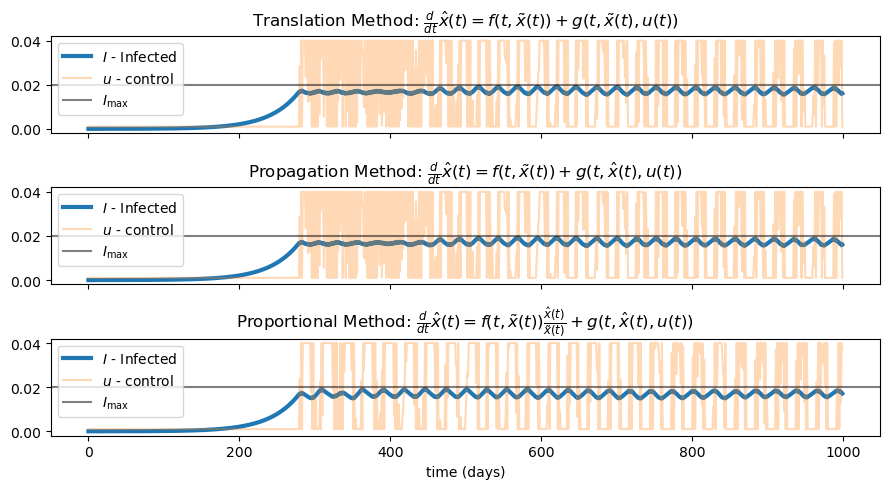

In [143]:
fig, ax = plt.subplots(3, figsize=(9,5), sharex=True)
# fig, ax = plt.subplots(len(strategies))

for i, (strategy, equation, states)  in enumerate(zip(strategies, equations, solutions_pred_optimal_lstm)):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=3)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.3)
    ax[i].axhline(i_max, label="$I_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("{} Method: {}".format(strategy.title(), equation))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_pred_optimal_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### Varying Cost Weights

In [38]:
strategy = strategies[0]
solutions_varying_cost_weights = []

for i, c3 in enumerate([10, 100, 1000]):
    states = simulate_learning_based_mpc(theta,
        simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="exact", problem="optimal_control_casadi")
    solutions_varying_cost_weights.append(states)

100%|██████████| 1000/1000 [00:00<00:00, 9669.20it/s]


In [293]:
filename = "predictor_files/solutions_varying_cost_weights.pkl"

pkl.dump(solutions_varying_cost_weights, open(filename, "wb"))
solutions_varying_cost_weights = pkl.load(open(filename, "rb"))

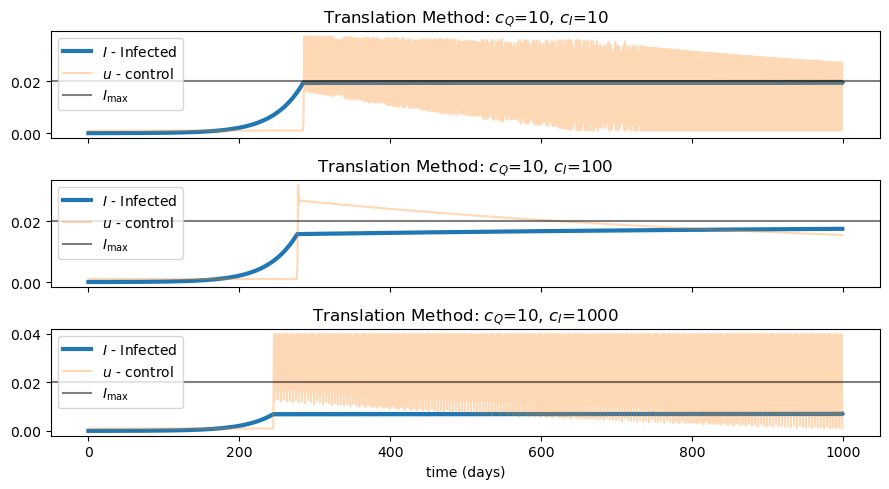

In [292]:
fig, ax = plt.subplots(3, figsize=(9,5), sharex=True)

for i, states  in enumerate(solutions_varying_cost_weights):
    ax[i].plot(states[:,1], label="$I$ - Infected", linewidth=3)
    ax[i].plot(states[:,-1], label="$u$ - control", alpha=0.3)
    ax[i].axhline(i_max, label="$I_{\max}$", color="k", alpha=0.5)

    ax[i].set_title("Translation Method: $c_Q$={}, $c_I$={}".format(c2, [10,100,1000][i]))
    ax[i].legend()

plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("predictor_figures/solutions_varying_cost_weights.svg", bbox_inches='tight', format="svg")
plt.show()

### Optimal Control - Shooting and Sweep

In [ ]:
solutions_pred_sweep_exact = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(b_real, g_real, gq_real,
        simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="exact", problem="optimal_control_sweep")
    solutions_pred_sweep_exact.append(states)

100%|██████████| 1000/1000 [01:06<00:00, 14.98it/s]


In [41]:
filename = "files/solutions_pred_sweep_exact.pkl"

# pkl.dump(solutions_pred_sweep_exact, open(filename, "wb"))
solutions_pred_sweep_exact = pkl.load(open(filename, "rb"))

In [ ]:
solutions_pred_shoot_exact = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(b_real, g_real, gq_real,
        simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="exact", problem="optimal_control_shooting")
    solutions_pred_shoot_exact.append(states)

100%|██████████| 1000/1000 [01:10<00:00, 14.26it/s]


In [40]:
filename = "files/solutions_pred_shoot_exact.pkl"

# pkl.dump(solutions_pred_shoot_exact, open(filename, "wb"))
solutions_pred_shoot_exact = pkl.load(open(filename, "rb"))

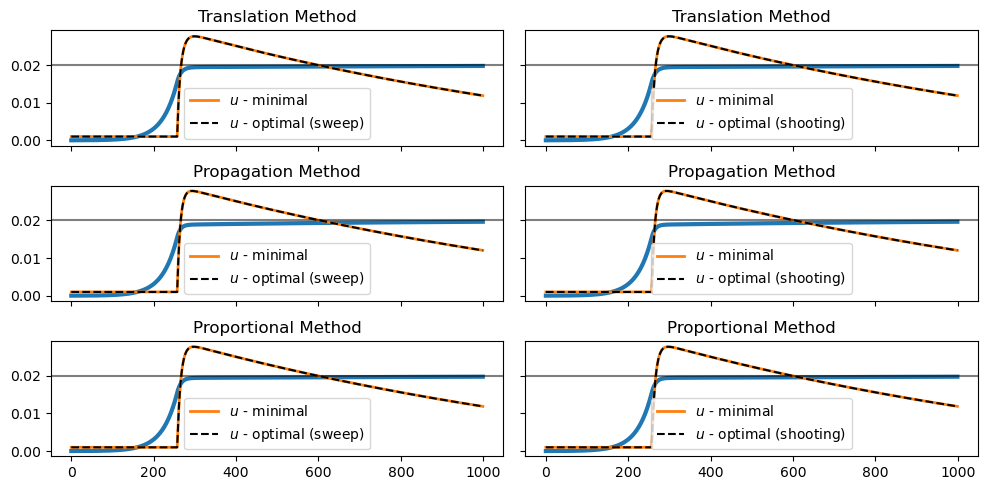

In [62]:
fig, ax = plt.subplots(3,2, figsize=(10,5), sharex=True, sharey=True)

for j, (method, solutions) in enumerate(zip(["sweep", "shooting"], [solutions_pred_sweep_exact, solutions_pred_shoot_exact])):
    for i, (strategy, equation, states, states_minimal)  in enumerate(zip(strategies, equations, solutions, solutions_pred_minimal_exact)):
        # plots sweep
        ax[i][j].plot(states[:,1], linewidth=3)
        ax[i][j].plot(states_minimal[:,-1], label="$u$ - minimal", linewidth=2)
        ax[i][j].plot(states[:,-1], '--', color="k", label="$u$ - optimal ({})".format(method))
        ax[i][j].axhline(i_max, color="k", alpha=0.5)

        ax[i][j].set_title("{} Method".format(strategy.title()))
        ax[i][j].legend()

# plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("fig/solutions_pred_sweep_shoot_exact.svg", bbox_inches='tight', format="svg")
plt.show()

In [ ]:
solutions_pred_sweep_lstm = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(b_real, g_real, gq_real,
        simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="lstm", problem="optimal_control_sweep")
    solutions_pred_sweep_lstm.append(states)

100%|██████████| 1000/1000 [00:51<00:00, 19.53it/s]


In [56]:
filename = "files/solutions_pred_sweep_lstm.pkl"

# pkl.dump(solutions_pred_sweep_lstm, open(filename, "wb"))
solutions_pred_sweep_lstm = pkl.load(open(filename, "rb"))

In [ ]:
solutions_pred_shoot_lstm = []

for i, strategy in enumerate(strategies):
    states = simulate_learning_based_mpc(b_real, g_real, gq_real,
        simulation_lenght=1000, start_lenght=input_lenght,
        strategy=strategy, prediction="lstm", problem="optimal_control_shooting")
    solutions_pred_shoot_lstm.append(states)

100%|██████████| 1000/1000 [00:54<00:00, 18.51it/s]


In [57]:
filename = "files/solutions_pred_shoot_lstm.pkl"

# pkl.dump(solutions_pred_shoot_lstm, open(filename, "wb"))
solutions_pred_shoot_lstm = pkl.load(open(filename, "rb"))

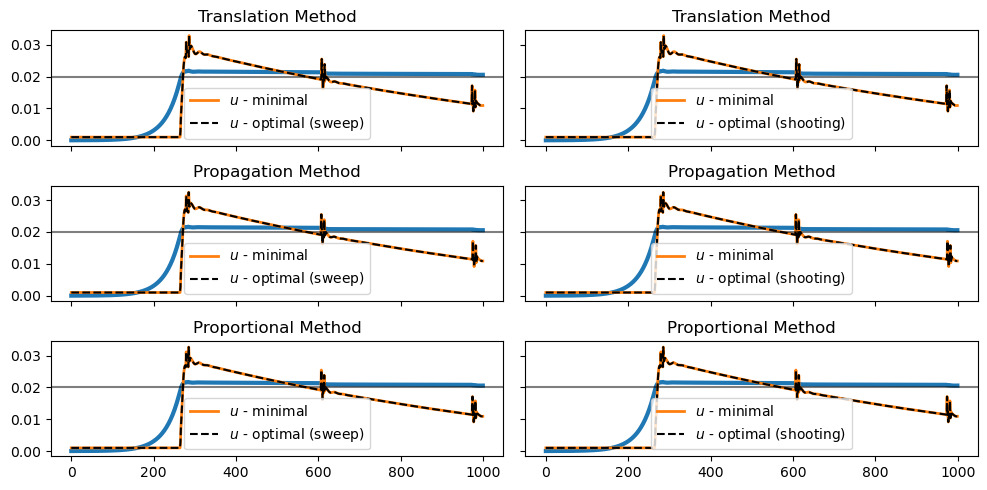

In [61]:
fig, ax = plt.subplots(3,2, figsize=(10,5), sharex=True, sharey=True)

for j, (method, solutions) in enumerate(zip(["sweep", "shooting"], [solutions_pred_sweep_lstm, solutions_pred_shoot_lstm])):
    for i, (strategy, equation, states, states_minimal)  in enumerate(zip(strategies, equations, solutions, solutions_pred_minimal_lstm)):
        # plots sweep
        ax[i][j].plot(states[:,1], linewidth=3)
        ax[i][j].plot(states_minimal[:,-1], label="$u$ - minimal", linewidth=2)
        ax[i][j].plot(states[:,-1], '--', color="k", label="$u$ - optimal ({})".format(method))
        ax[i][j].axhline(i_max, color="k", alpha=0.5)

        ax[i][j].set_title("{} Method".format(strategy.title()))
        ax[i][j].legend()

# plt.xlabel("time (days)")
fig.tight_layout()
plt.savefig("fig/solutions_pred_sweep_shoot_lstm.svg", bbox_inches='tight', format="svg")
plt.show()

### better discretizations

In [21]:
# define new parameters
beta = 0.04     # infection rate
gamma_i = 0.01  # recovery rate
gamma_q = 0.025 # recovery rate quarantine
mu_i = 0.002
mu_q = 0.001
delta = 0.001
theta = np.array([beta, gamma_i, gamma_q, mu_i, mu_q, delta])

In [26]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

100%|██████████| 500/500 [07:46<00:00,  1.07it/s]  


cost: 20.019779957436235
cost: 25.092070423627305
cost: 24.298379412029952


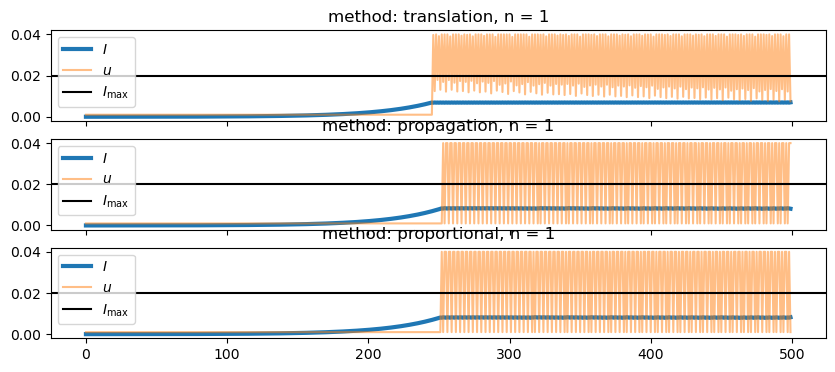

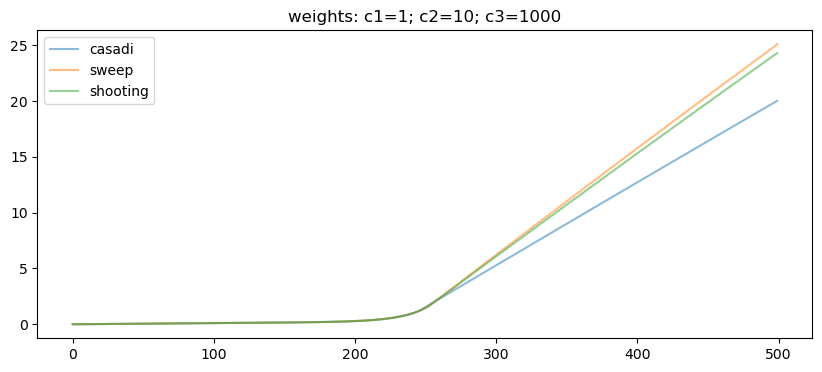

In [33]:
# n = 1
# h = 1/n
# output_lenght_aug = output_lenght * n

# c3 = 1000

# solutions = []

# strategy = "propagation"
# problems = ["casadi", "sweep", "shooting"]
# for problem in problems:
#         states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
#                 strategy=strategy, prediction="exact", problem=problem)
#         solutions.append(states)

# solutions_n_1_c3_1000 = solutions
# solutions = solutions_n_1_c3_1000

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

cost: 20.177928430848322
cost: 22.344274299752936
cost: 22.278352516477703


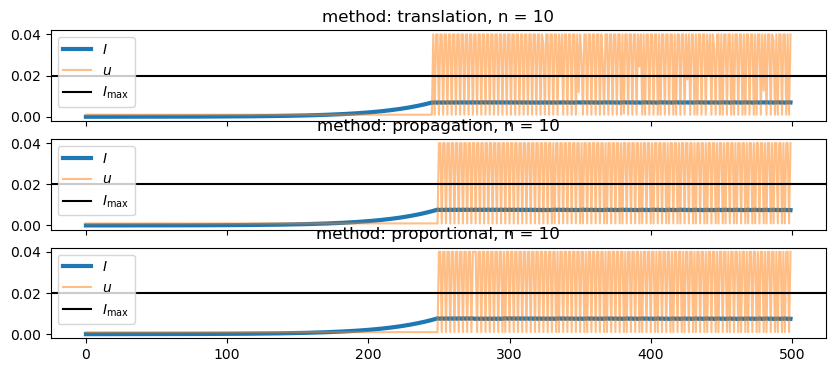

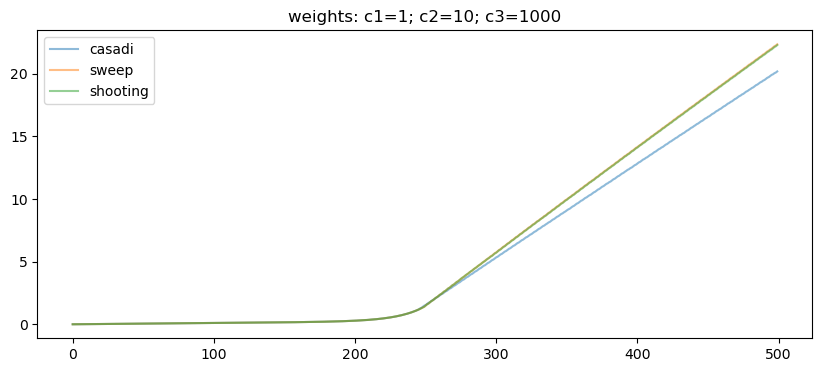

In [32]:
# n = 10
# h = 1/n
# output_lenght_aug = output_lenght * n

# c3 = 1000

# solutions = []

# strategy = "propagation"
# problems = ["casadi", "sweep", "shooting"]
# for problem in problems:
#         states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
#                 strategy=strategy, prediction="exact", problem=problem)
#         solutions.append(states)

# solutions_n_10_c3_1000 = solutions
# solutions = solutions_n_10_c3_1000

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

100%|██████████| 500/500 [06:08<00:00,  1.36it/s]  


cost: 12.297177491577365
cost: 21.325392023574718
cost: 20.63344399536943


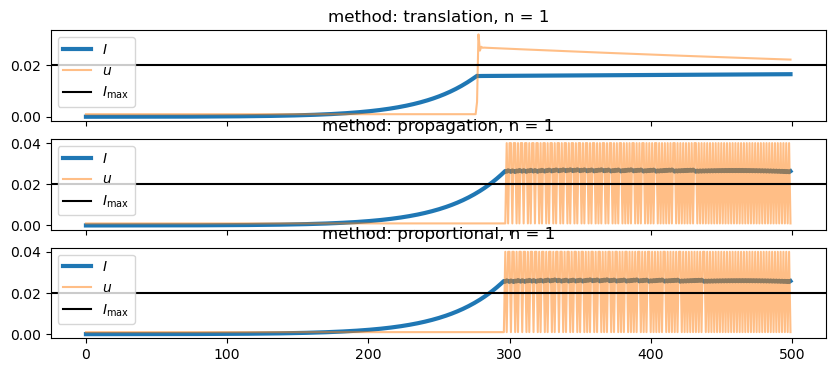

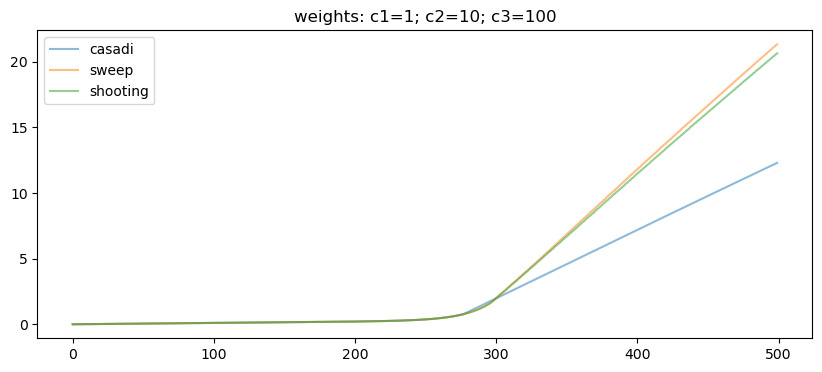

In [34]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

c3 = 100

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="exact", problem=problem)
        solutions.append(states)

solutions_n_1_c3_100 = solutions
solutions = solutions_n_1_c3_100

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

100%|██████████| 500/500 [05:10<00:00,  1.61it/s] 


cost: 14.674546983959164
cost: 18.911220493679025
cost: 18.86189385465314


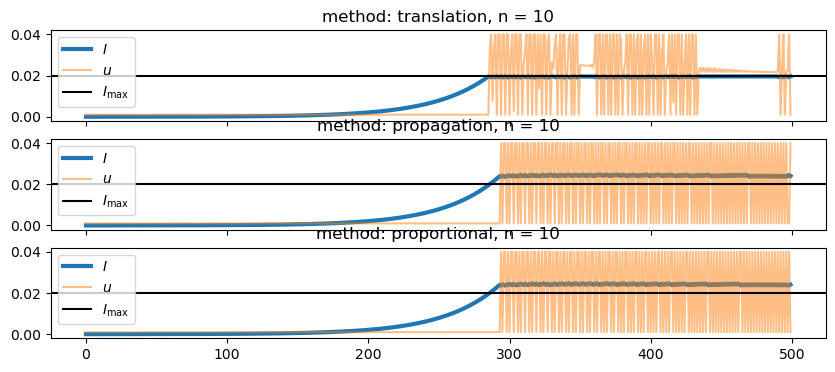

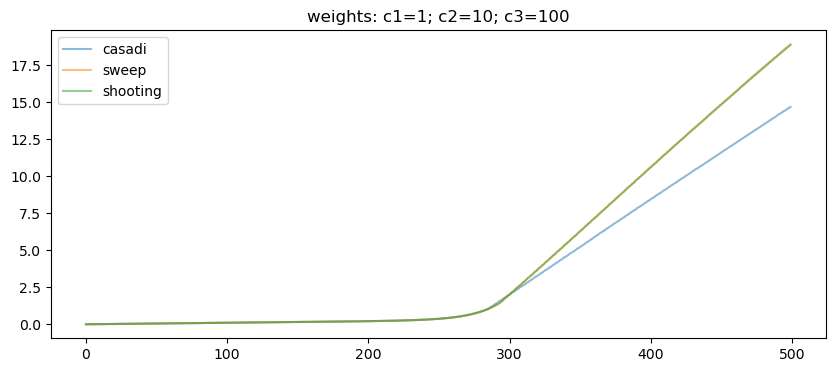

In [35]:
n = 10
h = 1/n
output_lenght_aug = output_lenght * n

c3 = 100

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="exact", problem=problem)
        solutions.append(states)

solutions_n_10_c3_100 = solutions
solutions = solutions_n_10_c3_100

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

cost: 21.325392023574718
cost: 18.911220493679025
cost: 18.729704859801036


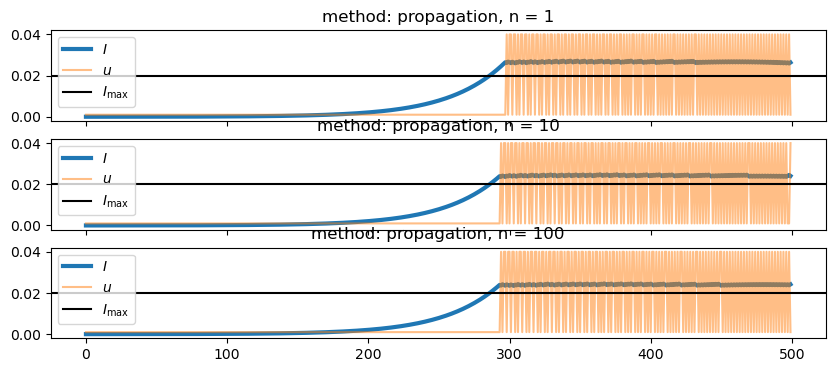

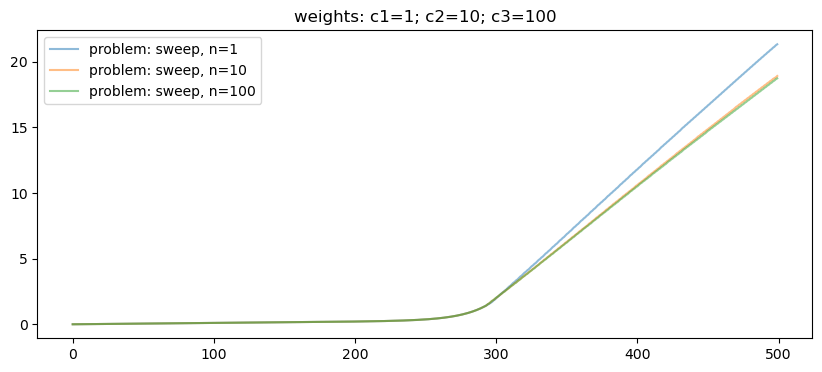

In [43]:
# n = 100
# h = 1/n
# output_lenght_aug = output_lenght * n

# c3 = 100

# solutions = []

# strategy = "propagation"
# problems = ["sweep"]
# for problem in problems:
#         states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
#                 strategy=strategy, prediction="exact", problem=problem)
#         solutions.append(states)

# solutions_n_100_c3_100 = solutions
# # solutions = solutions_n_100_c3_100
# solutions = [solutions_n_1_c3_100[1], solutions_n_10_c3_100[1], solutions_n_100_c3_100[0]]

# plots sweep
fig, ax = plt.subplots(len(solutions), figsize=(10,4), sharex=True)
for axi, n, states in zip(ax, [1, 10, 100], solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for n_, states in zip([1, 10, 100], solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label="problem: {}, n={}".format(problem, n_), alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

cost: 12.297177491577365
cost: 14.674546983959164


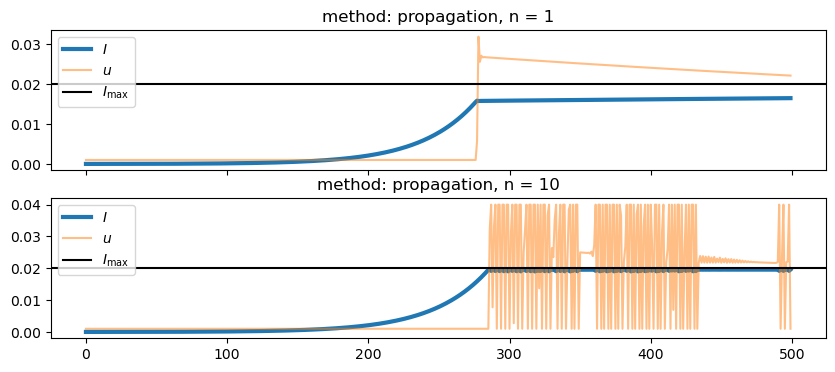

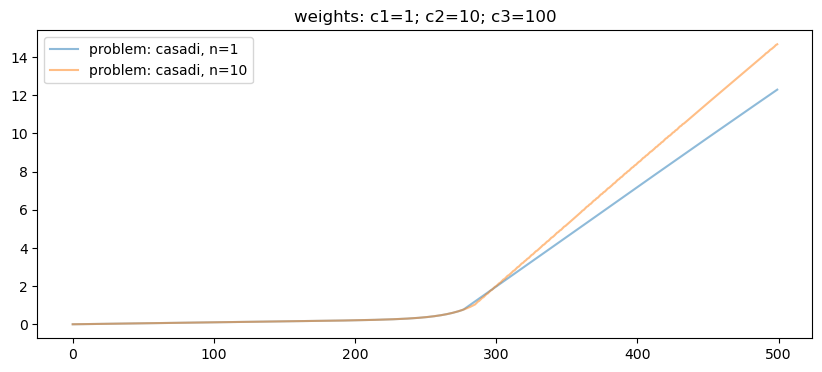

In [25]:
strategy = "propagation"
problem = "casadi"
solutions = [solutions_n_1_c3_100[0], solutions_n_10_c3_100[0]]

# plots sweep
fig, ax = plt.subplots(len(solutions), figsize=(10,4), sharex=True)
for axi, n, states in zip(ax, [1, 10], solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for n_, states in zip([1, 10], solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label="problem: {}, n={}".format(problem, n_), alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost:", cost[-1])

In [21]:
# pkl.dump((solutions_n_1_c3_1000, solutions_n_10_c3_1000, solutions_n_1_c3_100, solutions_n_10_c3_100), open("tests.bkp.txt", "wb"))
solutions_n_1_c3_1000, solutions_n_10_c3_1000, solutions_n_1_c3_100, solutions_n_10_c3_100 = pkl.load(open("tests.bkp.txt", "rb"))

### check numerical schemes

In [24]:
# define new parameters
beta = 0.04     # infection rate
gamma_i = 0.01  # recovery rate
gamma_q = 0.025 # recovery rate quarantine
mu_i = 0.002
mu_q = 0.001
delta = 0.001
theta = np.array([beta, gamma_i, gamma_q, mu_i, mu_q, delta])

cost casadi: 81.91788148634849
cost sweep: 83.12073903519102
cost shooting: 83.13380205016581


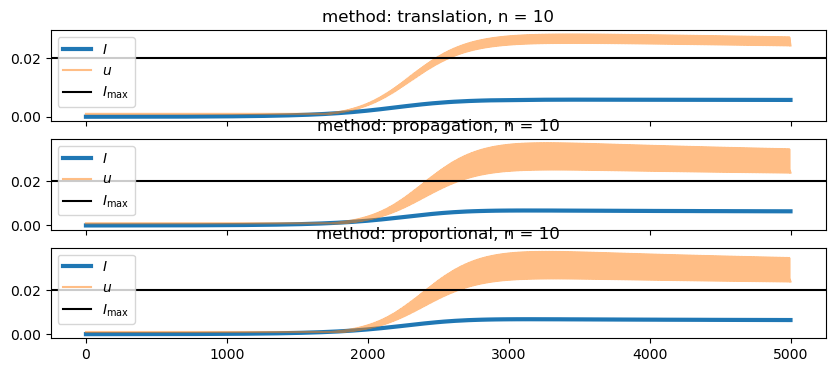

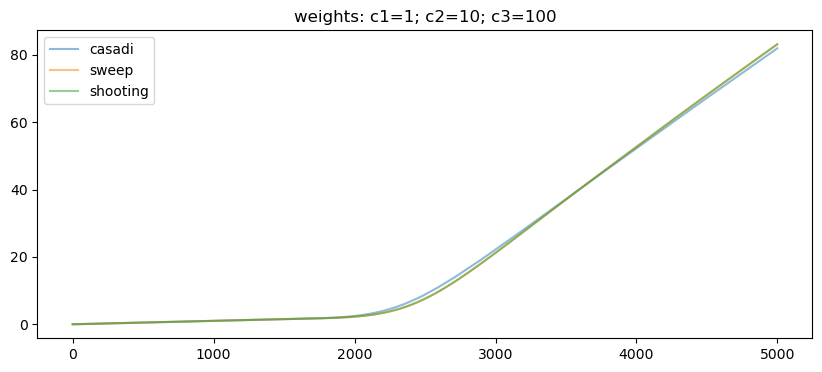

In [ ]:
n = 10
h = 1/n
output_lenght_aug = output_lenght * n

c3 = 100

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="exact", problem=problem)
        solutions.append(states)

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost {}:".format(problem), cost[-1])
        

100%|██████████| 500/500 [00:23<00:00, 20.86it/s]


cost casadi: 82.23270924788004
cost sweep: 85.49792544126394
cost shooting: 85.55734293528661


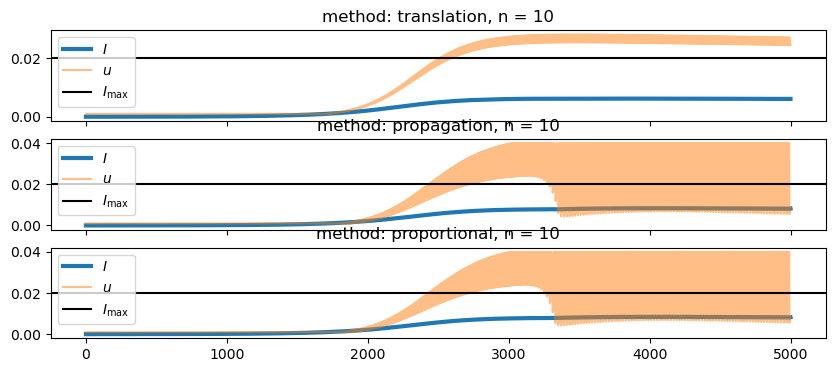

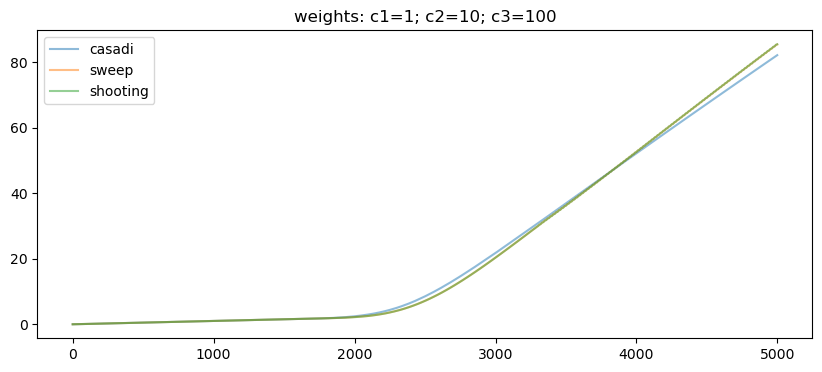

In [35]:
n = 10
h = 1/n
output_lenght_aug = output_lenght * n

c3 = 100

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="lstm", problem=problem)
        solutions.append(states)

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost {}:".format(problem), cost[-1])
        

100%|██████████| 500/500 [00:15<00:00, 32.41it/s]


cost casadi: 8.09741670750672
cost sweep: 8.23862804655388
cost shooting: 8.23210639227229


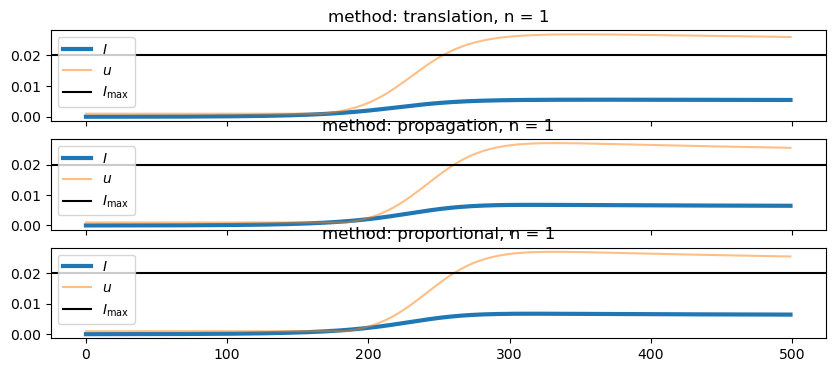

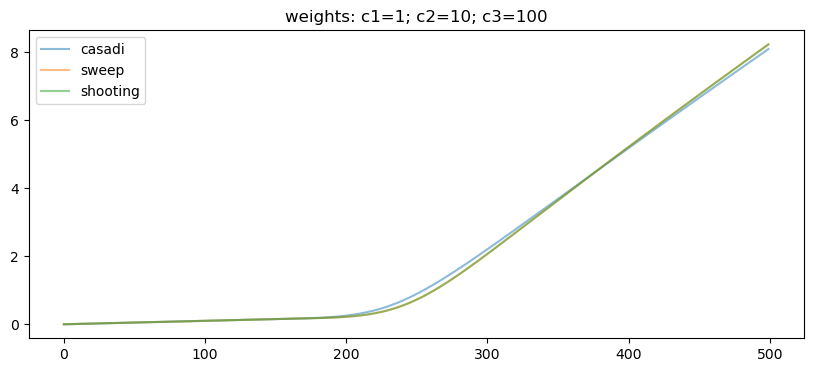

In [62]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

c3 = 100

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="lstm", problem=problem)
        solutions.append(states)

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost {}:".format(problem), cost[-1])
        

100%|██████████| 500/500 [00:00<00:00, 589.45it/s]


cost casadi: 5.484159433939267
cost sweep: 4.6590603840339755
cost shooting: 4.657518131665822


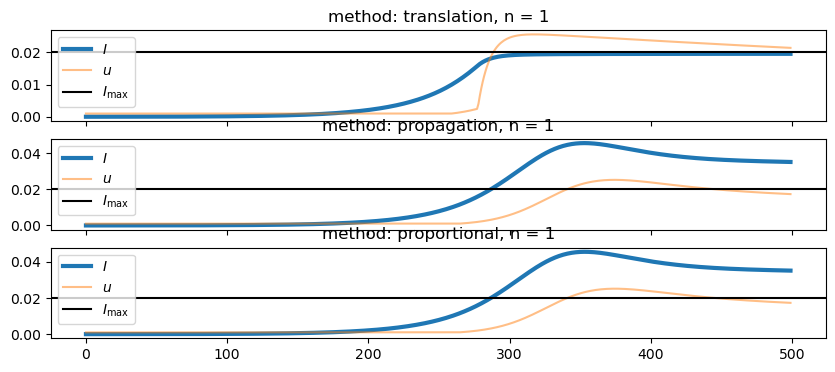

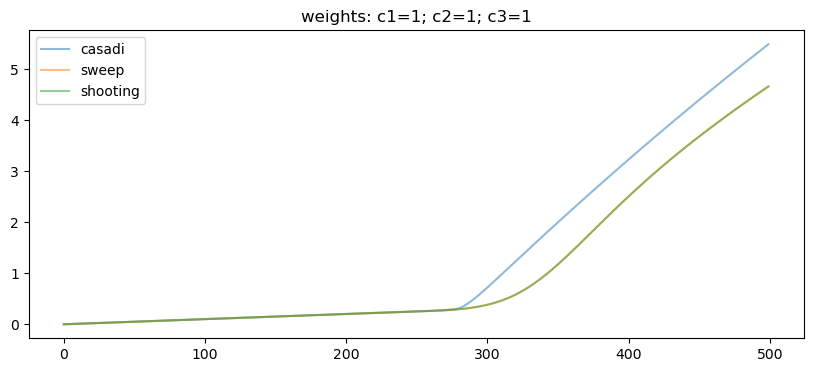

In [65]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

c2 = 1
c3 = 1

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="exact", problem=problem)
        solutions.append(states)

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost {}:".format(problem), cost[-1])
        

100%|██████████| 500/500 [00:15<00:00, 31.83it/s]


cost casadi: 5.4604611147465585
cost sweep: 4.644833780284856
cost shooting: 4.6430125994145


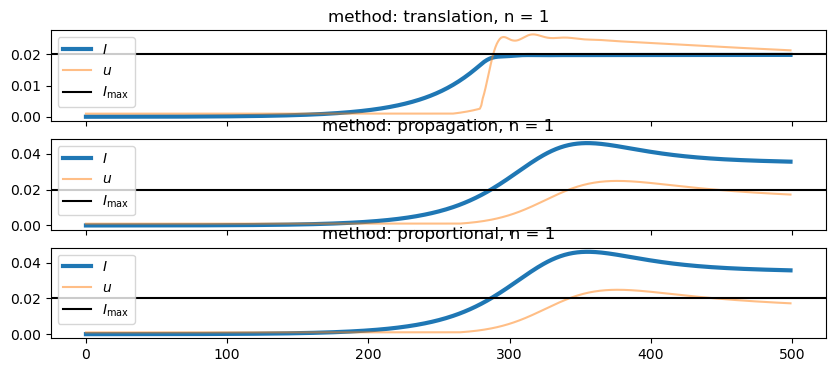

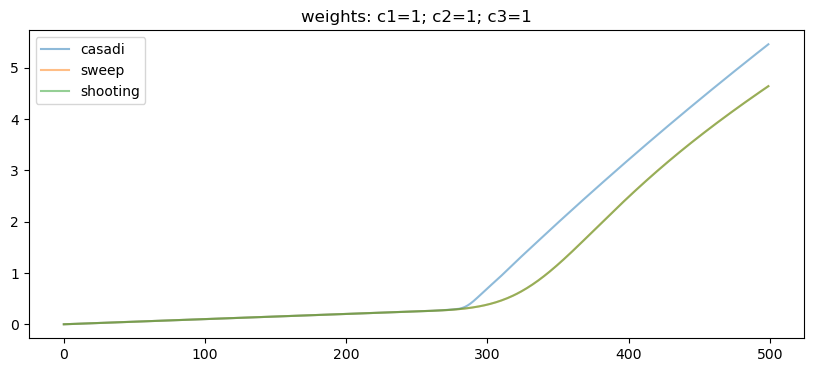

In [63]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

c2 = 1
c3 = 1

solutions = []

strategy = "propagation"
problems = ["casadi", "sweep", "shooting"]
for problem in problems:
        states = simulate_learning_based_mpc(theta, simulation_lenght=500, start_lenght=input_lenght,
                strategy=strategy, prediction="lstm", problem=problem)
        solutions.append(states)

# plots sweep
fig, ax = plt.subplots(len(problems), figsize=(10,4), sharex=True)
for axi, strategy, states in zip(ax, strategies, solutions):
        axi.plot(states[:,1], label="$I$", linewidth=3)
        axi.plot(states[:,-1], label="$u$", alpha=0.5)
        axi.axhline(i_max, label="$I_\\max$", color="k")

        axi.set_title("method: {}, n = {}".format(strategy, n))
        axi.legend()

#
plt.figure(figsize=(10,4))

for problem, states in zip(problems, solutions):
        cost = np.cumsum(c1*states[:,-1]*(1-states[:,3]) + c2*states[:,3]**2 + c3*states[:,1]**2)
        plt.plot(cost, label=problem, alpha=0.5)
        plt.title("weights: c1={}; c2={}; c3={}".format(c1, c2, c3))
        plt.legend()

        print("cost {}:".format(problem), cost[-1])
        

In [349]:
def sweep_method_step(x, p, u, x_0, p_t, f_x, f_p, f_u):
    # updates x(t) forwards in time
    x[:,0] = x_0
    for i in range(1, output_lenght_aug):
        x[:,i] = x[:,i-1] + h*f_x(i-1, x[:,i-1], u[i-1])
    
    # updates p(t) backwards in time
    p[:,-1] = p_t
    for i in range(output_lenght_aug-1, 0, -1):
        p[:,i-1] = p[:,i] - h*f_p(i,p[:,i], x[:,i], u[i-1]) # attention to the signals

    # updates u(t) at each time
    for i in range(output_lenght_aug-1):
        u[i] = f_u(i, p[:,i], x[:,i], u[i])

    return x, p, u

def shooting_method_step(x, p, u, x_0, p_0, f_x, f_p, f_u):
    # updates x(t) and p(t) forwards in time
    x[:,0] = x_0
    p[:,0] = p_0
    for i in range(1,output_lenght_aug):
        u[i-1] = f_u(i-1, p[:,i-1], x[:,i-1], u[i-1])
        x[:,i] = x[:,i-1] + h*f_x(i-1, x[:,i-1], u[i-1])
        p[:,i] = p[:,i-1] + h*f_p(i-1, p[:,i-1], x[:,i-1], u[i-1]) # attention to the signals

    return x, p, u

from scipy.optimize import root

def shooting_method_step_p_0(x, p, u, x_0, p_0, p_t, f_x, f_p, f_u):
    root_scalar_f = lambda p_0: shooting_method_step(x.copy(), p.copy(), u.copy(), x_0, p_0.copy(), f_x, f_p, f_u)[1][:,-1] - p_t
    res = root(root_scalar_f, x0=p_0)
    return res["x"]

def mpc_optimal_control_problem_numerical(method, strategy, i_pred, x_0, u_min, u_max, N=5000, tol=1e-8):
    p_t = np.array([0,0,1])
    p_0 = np.array([1,1,1])
    # p_0 = np.random.rand(3)
    x_0 = np.array([*x_0, 0])

    u = np.zeros(output_lenght_aug)
    x = np.zeros((3, output_lenght_aug))#; x[:,0] = x_0
    p = np.ones((3, output_lenght_aug))#; p[:,-1] = p_t
    
    # defines mappings
    f_x, f_p, f_u = get_functions_(strategy, i_pred, u_min, u_max)

    for i in range(N):
        x_old, p_old, u_old = x.copy(), p.copy(), u.copy()

        if method == "sweep":
            x, p, u = sweep_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_t.copy(), f_x, f_p, f_u)
        
        if method == "shooting":
            p_0 = shooting_method_step_p_0(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), p_t.copy(), f_x, f_p, f_u) 
            x, p, u = shooting_method_step(x_old.copy(), p_old.copy(), u_old.copy(), x_0.copy(), p_0.copy(), f_x, f_p, f_u)
        
        states = np.concatenate([arr.ravel() for arr in (x, p, u)])
        states_old = np.concatenate([arr.ravel() for arr in (x_old, p_old, u_old)])
        stopping_criterion_error = np.linalg.norm(states - states_old)/np.linalg.norm(states) 
        
        # check for stopping condition
        if stopping_criterion_error < tol:
            break
    else:
        print("warning: maximun iteration reached. criterion:", stopping_criterion_error)

    return u[:n], u.copy()

In [ ]:
n = 10
h = 1/n
output_lenght_aug = output_lenght * n

strategy = "propagation"
problem = "shooting"

simulator = simulate_learning_based_mpc(theta, simulation_lenght=500,
                                        start_lenght=input_lenght,
                                        strategy=strategy,
                                        prediction="exact",
                                        problem=problem)
    
for i in range(500):
    states, data_casadi, data_sweep, data_shooting, costs_casadi, costs_sweep, costs_shooting = next(simulator)

100%|█████████▉| 499/500 [01:59<00:00,  3.61it/s]

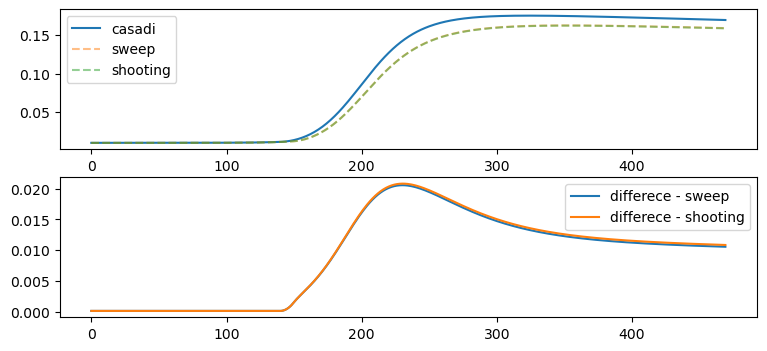

In [ ]:
_, ax = plt.subplots(2, figsize=(9,4))

ax[0].plot(costs_casadi, label="casadi")
ax[0].plot(costs_sweep, "--", label="sweep", alpha=0.5)
ax[0].plot(costs_shooting, "--", label="shooting", alpha=0.5)
ax[0].legend()

ax[1].plot(np.array(costs_casadi)-np.array(costs_sweep), label="differece - sweep")
ax[1].plot(np.array(costs_casadi)-np.array(costs_shooting), label="differece - shooting")
ax[1].legend()

In [51]:
n = 10
h = 1/n
output_lenght_aug = output_lenght * n

strategy = "propagation"
problem = "shooting"

simulator = simulate_learning_based_mpc(theta, simulation_lenght=500,
                                        start_lenght=input_lenght,
                                        strategy=strategy,
                                        prediction="lstm",
                                        problem=problem)
    
for i in range(500):
    states, data_casadi, data_sweep, data_shooting, costs_casadi, costs_sweep, costs_shooting = next(simulator)

100%|█████████▉| 499/500 [02:24<00:00,  3.04it/s]

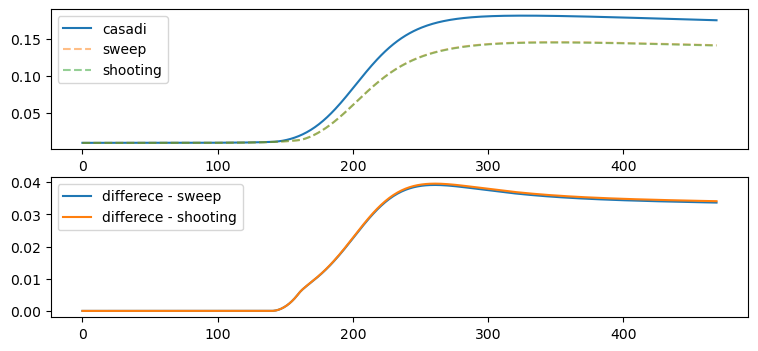

In [52]:
_, ax = plt.subplots(2, figsize=(9,4))

ax[0].plot(costs_casadi, label="casadi")
ax[0].plot(costs_sweep, "--", label="sweep", alpha=0.5)
ax[0].plot(costs_shooting, "--", label="shooting", alpha=0.5)
ax[0].legend()

ax[1].plot(np.array(costs_casadi)-np.array(costs_sweep), label="differece - sweep")
ax[1].plot(np.array(costs_casadi)-np.array(costs_shooting), label="differece - shooting")
ax[1].legend()

In [53]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

strategy = "propagation"
problem = "shooting"

simulator = simulate_learning_based_mpc(theta, simulation_lenght=500,
                                        start_lenght=input_lenght,
                                        strategy=strategy,
                                        prediction="exact",
                                        problem=problem)
    
for i in range(500):
    states, data_casadi, data_sweep, data_shooting, costs_casadi, costs_sweep, costs_shooting = next(simulator)

 99%|█████████▊| 493/500 [00:05<00:00, 76.24it/s] 

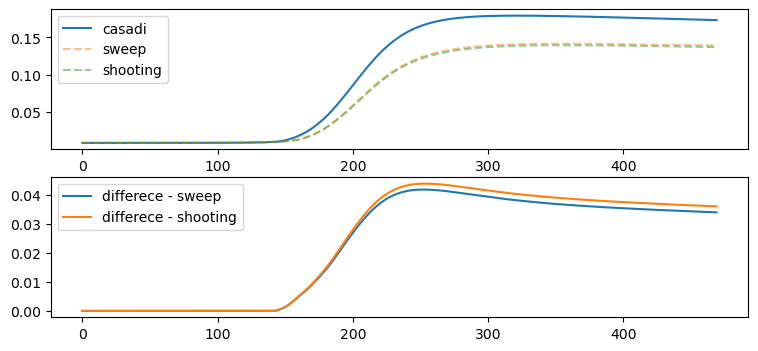

 99%|█████████▊| 493/500 [00:23<00:00, 76.24it/s]

In [54]:
_, ax = plt.subplots(2, figsize=(9,4))

ax[0].plot(costs_casadi, label="casadi")
ax[0].plot(costs_sweep, "--", label="sweep", alpha=0.5)
ax[0].plot(costs_shooting, "--", label="shooting", alpha=0.5)
ax[0].legend()

ax[1].plot(np.array(costs_casadi)-np.array(costs_sweep), label="differece - sweep")
ax[1].plot(np.array(costs_casadi)-np.array(costs_shooting), label="differece - shooting")
ax[1].legend()

In [55]:
n = 1
h = 1/n
output_lenght_aug = output_lenght * n

strategy = "propagation"
problem = "shooting"

simulator = simulate_learning_based_mpc(theta, simulation_lenght=500,
                                        start_lenght=input_lenght,
                                        strategy=strategy,
                                        prediction="lstm",
                                        problem=problem)
    
for i in range(500):
    states, data_casadi, data_sweep, data_shooting, costs_casadi, costs_sweep, costs_shooting = next(simulator)

100%|█████████▉| 499/500 [00:20<00:00, 22.57it/s]

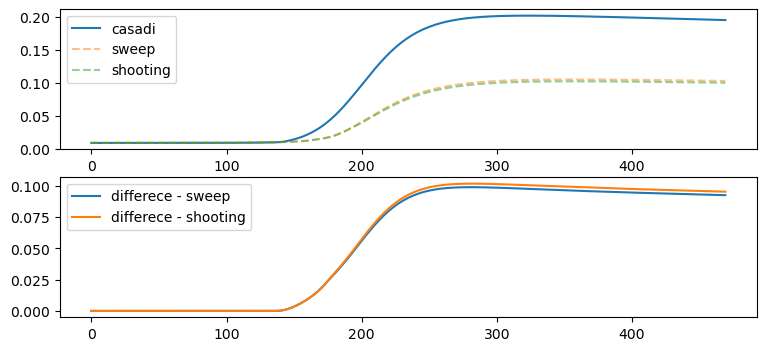

100%|█████████▉| 499/500 [00:33<00:00, 22.57it/s]

In [56]:
_, ax = plt.subplots(2, figsize=(9,4))

ax[0].plot(costs_casadi, label="casadi")
ax[0].plot(costs_sweep, "--", label="sweep", alpha=0.5)
ax[0].plot(costs_shooting, "--", label="shooting", alpha=0.5)
ax[0].legend()

ax[1].plot(np.array(costs_casadi)-np.array(costs_sweep), label="differece - sweep")
ax[1].plot(np.array(costs_casadi)-np.array(costs_shooting), label="differece - shooting")
ax[1].legend()